# ISee Survey Analysis

## Import Libraries

In [84]:
import os
import json
import re
import requests
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [85]:
import textstat
import statsmodels.api as sm
import difflib
from scipy.stats import pearsonr
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [136]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Lasal
[nltk_data]     Jayawardena\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [86]:
import warnings
warnings.filterwarnings('ignore')

## Load the Data

In [25]:
with open("./data/user_interaction_rich_data.json", "r") as f:
    user_interaction_rich_data = json.load(f)

In [50]:
with open("./data/intents_used_results_with_exp.json", "r") as f:
    intents_evolve_dict = json.load(f)

In [60]:
for interaction in user_interaction_rich_data:
    
    intents_persona = intents_evolve_dict[interaction]

    persona = list(intents_persona["original_question"][0].values())[0]["persona"]
    user_interaction_rich_data[interaction]["user_persona"] = persona

## Explainer Type Distributions

In [30]:
def plot_bar_chart(values, title):
    """
    Plots a bar chart using Seaborn with a blueish theme.

    Args:
        values (list of float or int): A list of numeric values to plot.
        title (str): The title for the bar chart.

    Raises:
        ValueError: If 'values' is empty.
    """
    # Check that the values list is not empty
    if not values:
        raise ValueError("The list of values is empty. Please provide at least one value.")

    # Set the Seaborn theme for a blueish color palette and a clean white grid
    sns.set_theme(style="whitegrid", palette="Blues_d")
    
    # Create x-axis labels (e.g., "Item 1", "Item 2", ...)
    x_labels = [f"Item {i+1}" for i in range(len(values))]
    
    # Create a DataFrame to facilitate plotting with Seaborn
    data = pd.DataFrame({
        "Category": x_labels,
        "Value": values
    })
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Category", y="Value", data=data, edgecolor=".2")
    
    # Set title and labels with appropriate font sizes
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel("Categories", fontsize=14)
    ax.set_ylabel("Values", fontsize=14)
    
    # Rotate x-tick labels for better readability if necessary
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [31]:
def plot_pie_chart(npout, title):
    """
    Plots a pie chart using Matplotlib with a blueish color palette.
    
    Args:
        npout (list of str or int): A list containing either numeric values 
                                    (for slice sizes) or categorical strings 
                                    (which will be counted to determine slice sizes).
        title (str): The title for the pie chart.
    
    Raises:
        ValueError: If 'npout' is empty.
    """
    if not npout:
        raise ValueError("The input list is empty. Please provide at least one element.")

    # Try to determine if the first element is numeric.
    try:
        float(npout[0])
        is_numeric = True
    except (ValueError, TypeError):
        is_numeric = False

    if is_numeric:
        # If the input is numeric, convert all elements to float and use default labels.
        values = [float(x) for x in npout]
        labels = [f"Item {i+1}" for i in range(len(values))]
    else:
        # If the input is categorical (strings), count the frequency of each unique element.
        series = pd.Series(npout)
        counts = series.value_counts()
        labels = counts.index.tolist()
        values = counts.values.tolist()

    # Set the Seaborn theme for a clean look (note: this doesn't affect the pie chart much)
    sns.set_theme(style="whitegrid")
    # Use a blueish color palette with as many colors as there are slices.
    colors = sns.color_palette("Blues_d", len(values))
    
    # Create the pie chart.
    plt.figure(figsize=(8, 8))
    plt.pie(
        values, 
        labels=labels, 
        autopct='%1.1f%%',  # Show percentage on each slice.
        startangle=140,    # Rotate start angle for better visualization.
        colors=colors, 
        wedgeprops={'edgecolor': 'black'}  # Add a border around each slice.
    )
    
    plt.title(title, fontsize=16, pad=20)
    plt.axis('equal')  # Ensure the pie chart is drawn as a circle.
    plt.show()

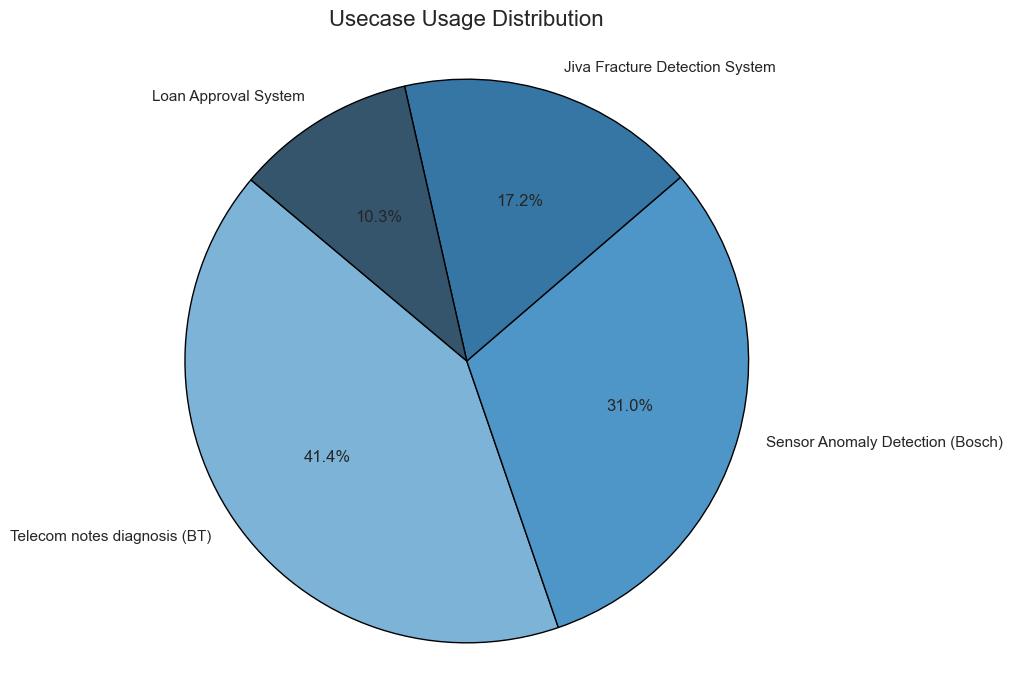

In [35]:
chart_title = "Usecase Usage Distribution"

plot_pie_chart([user_interaction_rich_data[x]['usecase_name'] for x in user_interaction_list], chart_title)

In [36]:
def flatten_2d_array(two_d_array):
    """
    Flattens a 2D list into a 1D list.

    Args:
        two_d_array (list of list): A 2D list (or jagged list) to be flattened.

    Returns:
        list: A 1D list containing all the elements of the 2D list.

    Raises:
        TypeError: If an element of two_d_array is not a list.
    """
    flattened = []
    for row in two_d_array:
        if isinstance(row, list):
            flattened.extend(row)
        else:
            raise TypeError("Each element of the input should be a list.")
    return flattened

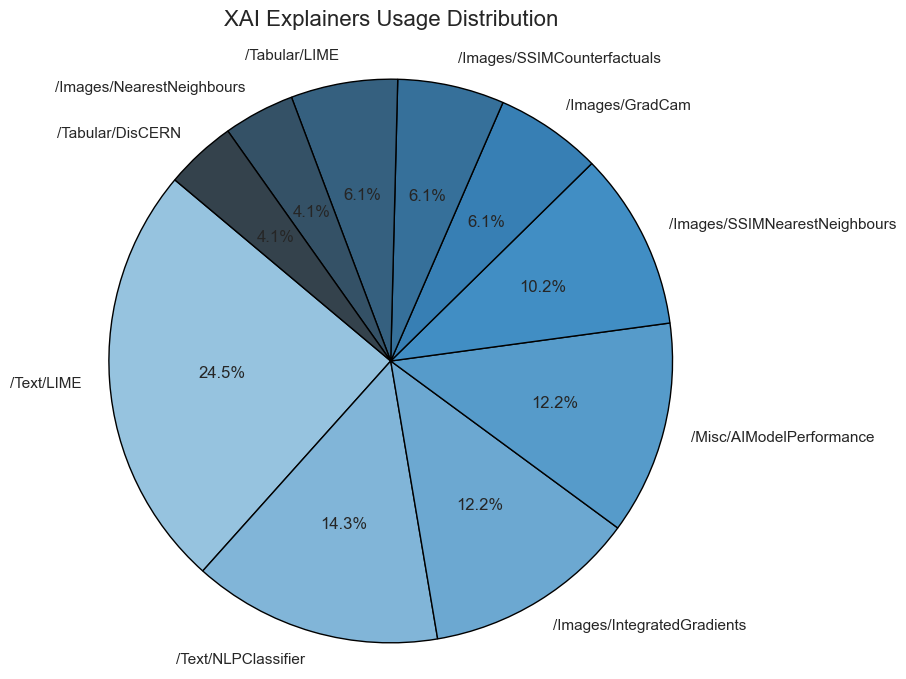

In [37]:
chart_title = "XAI Explainers Usage Distribution"

plot_pie_chart(flatten_2d_array([user_interaction_rich_data[x]['explainers_used'] for x in user_interaction_list]), chart_title)

## Word Cloud Plots

In [33]:
def generate_word_cloud(words, title="Word Cloud", save_path=None, remove_stopwords=True):
    """
    Generates and displays a word cloud with optional stopword removal.

    Args:
        words (list or dict): 
            - If a list is provided, the function calculates word frequencies.
            - If a dictionary is provided, it should map words to their frequencies.
        title (str, optional): Title for the word cloud plot. Default is "Word Cloud".
        save_path (str, optional): If provided, saves the word cloud image to the given file path.
        remove_stopwords (bool, optional): If True, removes common stopwords. Default is True.

    Raises:
        ValueError: If the input is neither a list nor a dictionary.
    """
    # Determine whether input is a list (convert to frequencies) or a dictionary
    if isinstance(words, list):
        # Convert list of words into a frequency dictionary
        word_freq = {word: words.count(word) for word in set(words)}
    elif isinstance(words, dict):
        word_freq = words
    else:
        raise ValueError("Input must be a list of words or a dictionary of word frequencies.")

    # Remove stopwords if enabled
    if remove_stopwords:
        stopwords = set(STOPWORDS)
        word_freq = {word: freq for word, freq in word_freq.items() if word.lower() not in stopwords}

    # Generate a blueish color palette using seaborn
    color_palette = sns.color_palette("Blues", as_cmap=True)

    # Create word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color="white",
        colormap="Blues", max_words=200
    ).generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title(title, fontsize=16, pad=15)
    plt.tight_layout()

    # Save image if a save path is provided
    if save_path:
        wordcloud.to_file(save_path)
        print(f"Word cloud saved as {save_path}")

    # Show the plot
    plt.show()
    

In [39]:
clr_questions = []
clr_answers = []

for x in [user_interaction_rich_data[x]["clarifictaion_segment"] for x in user_interaction_list]:
    for y in x:
        # print()
        clr_questions.append(y[0]["clarification_question"])
        clr_answers.append(y[1]['llm_response'])

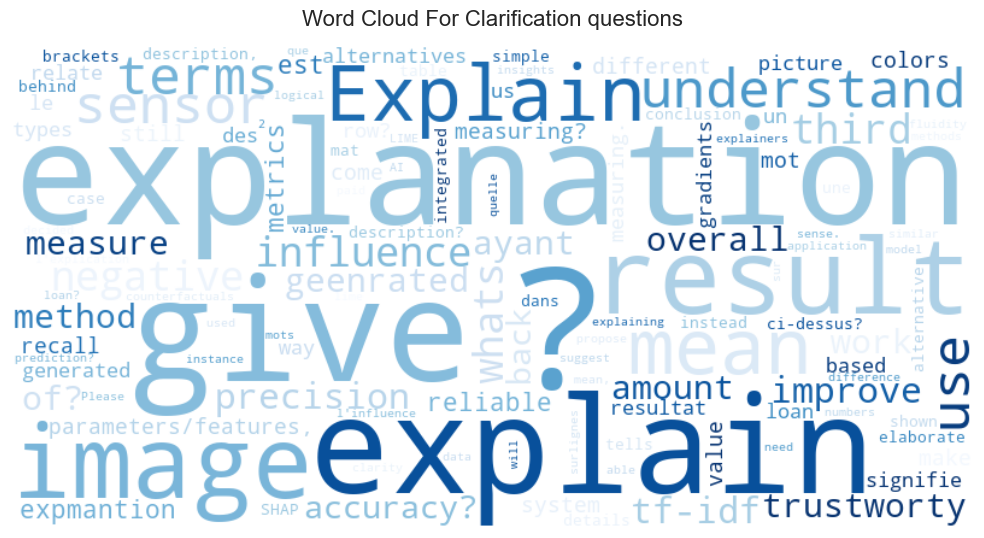

In [40]:
words_list = flatten_2d_array([x.split() for x in clr_questions])
generate_word_cloud(words_list, title="Word Cloud For Clarification questions")

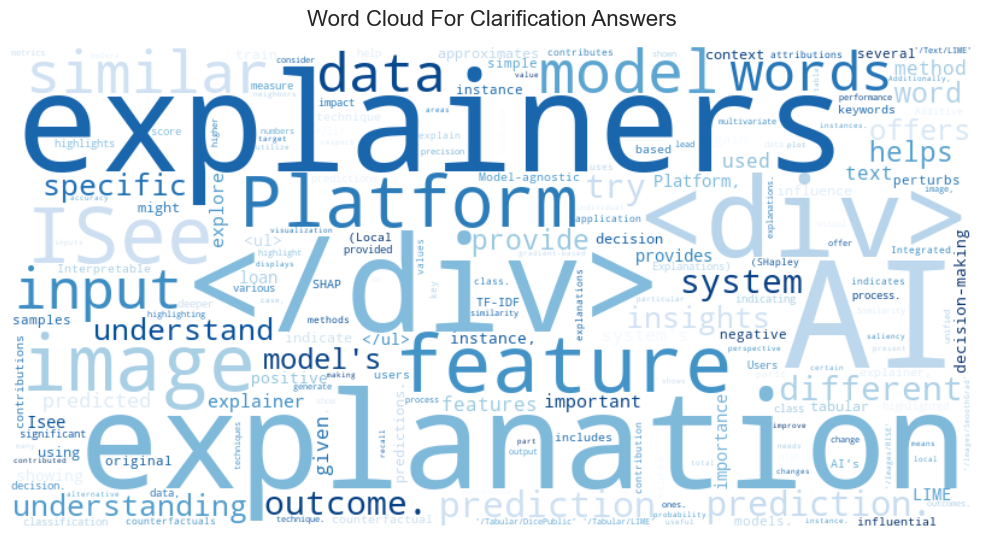

In [41]:
words_list = flatten_2d_array([x.split() for x in clr_answers])
generate_word_cloud(words_list, title="Word Cloud For Clarification Answers")

## Correlation Analysis

In [63]:
llm_interaction 

[[{'clarification_question': 'what other explanation do you suggest for my use case ?'},
  {'llm_response': "<div>\n  For your use case, another explanation method you might consider is the SHAP (SHapley Additive exPlanations) technique. SHAP values provide a unified measure of feature importance, showing how each feature contributes to the prediction. This can help you understand the impact of each feature on the model's decision. In the ISee Platform, you can try out explainers like '/Tabular/TreeSHAPGlobal' and '/Tabular/TreeSHAPLocal' for multivariate tabular data, which utilize SHAP values to provide insights into feature contributions.\n\n  Additionally, LIME (Local Interpretable Model-agnostic Explanations) is a popular choice. It approximates the model locally with an interpretable model to explain individual predictions, which can be useful for understanding specific instances. The ISee Platform offers '/Tabular/LIME' for multivariate tabular data, which perturbs input data sa

In [69]:
qa_interaction_data = {}

count = 0
for idx, interaction in user_interaction_rich_data.items():
    usecase_name = interaction["usecase_name"]
    explainer_types = interaction["explainers_used"]
    llm_interaction = interaction["clarifictaion_segment"]
    user_persona = interaction["user_persona"]
    clarification_dict = {x[0]["clarification_question"].lower().strip(): x[1]["llm_response"] for x in llm_interaction}

    for clarification in llm_interaction:
        question = clarification[0]["clarification_question"]
        answer = clarification_dict[question.lower()]
        qa_interaction_data[question] = {
            "usecase_name": usecase_name,
            "explainer_types": explainer_types,
            "question": question,
            "answer": answer,
            "user_persona":user_persona,

        }
        count += 1

In [82]:
def analyze_interaction_metrics(data, predictors=None):
    """
    Analyzes readability, complexity, and reasonability scores for user interactions.
    
    Each dictionary in the input list should contain:
      - "usecase_name": String (categorical)
      - "explainer_types": List of strings (e.g., ["Type A", "Visual"])
      - "question": String
      - "answer": String
      - "user_persona": String (categorical)
      - "reasonability_score": Integer between 1 and 10
    
    The function computes a variety of text metrics for both questions and answers,
    displays a detailed summary of the initial DataFrame, shows an enlarged full correlation heatmap
    (excluding the "Reasonability Score"), prints the top 10 most correlated pairs between question
    and answer metrics (excluding outcome columns), displays a separate heatmap for these top correlations,
    and performs regression analysis to predict the reasonability score using selected predictors.
    
    Args:
        data (list of dicts): List of interaction data dictionaries.
        predictors (list of str, optional): List of column names to use as predictors in regression.
            If None, a default set will be used.
    
    Returns:
        pd.DataFrame: The DataFrame containing computed metrics for each interaction.
    """
    import os
    import textstat
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MultiLabelBinarizer

    # -------------------- Compute Metrics --------------------
    results = []
    for interaction in data:
        usecase_name         = interaction.get("usecase_name", None)
        explainer_types      = interaction.get("explainer_types", [])  # expected list
        question             = interaction.get("question", "")
        answer               = interaction.get("answer", "")
        user_persona         = interaction.get("user_persona", None)
        
        metrics = {
            # Basic counts:
            "Question Length": len(question),
            "Answer Length": len(answer),
            "Question Word Count": textstat.lexicon_count(question, removepunct=True),
            "Answer Word Count": textstat.lexicon_count(answer, removepunct=True),
            "Question Sentence Count": textstat.sentence_count(question),
            "Answer Sentence Count": textstat.sentence_count(answer),
            "Question Syllable Count": textstat.syllable_count(question),
            "Answer Syllable Count": textstat.syllable_count(answer),
            
            # Averages:
            "Question Avg Words per Sentence": textstat.lexicon_count(question) / max(1, textstat.sentence_count(question)),
            "Question Avg Syllables per Word": textstat.syllable_count(question) / max(1, textstat.lexicon_count(question)),
            "Answer Avg Words per Sentence": textstat.lexicon_count(answer) / max(1, textstat.sentence_count(answer)),
            "Answer Avg Syllables per Word": textstat.syllable_count(answer) / max(1, textstat.lexicon_count(answer)),
            
            # Readability for question:
            "Question Flesch Reading Ease": textstat.flesch_reading_ease(question),
            "Question Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(question),
            "Question Gunning Fog Index": textstat.gunning_fog(question),
            "Question SMOG Index": textstat.smog_index(question),
            "Question Dale-Chall Score": textstat.dale_chall_readability_score(question),
            "Question Coleman-Liau Index": textstat.coleman_liau_index(question),
            
            # Readability for answer:
            "Answer Flesch Reading Ease": textstat.flesch_reading_ease(answer),
            "Answer Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(answer),
            "Answer Gunning Fog Index": textstat.gunning_fog(answer),
            "Answer SMOG Index": textstat.smog_index(answer),
            "Answer Dale-Chall Score": textstat.dale_chall_readability_score(answer),
            "Answer Coleman-Liau Index": textstat.coleman_liau_index(answer),
            
            # Outcome and categoricals:
            "Usecase Name": usecase_name,
            "Explainer Types": explainer_types,  
            "User Persona": user_persona,
        }
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # -------------------- Process "Explainer Types" --------------------
    if "Explainer Types" in df.columns and not df["Explainer Types"].isnull().all():
        sample_val = df["Explainer Types"].dropna().iloc[0]
        if isinstance(sample_val, list):
            mlb = MultiLabelBinarizer()
            explainer_dummies = pd.DataFrame(
                mlb.fit_transform(df["Explainer Types"]),
                columns=[f"Explainer Types_{cat}" for cat in mlb.classes_],
                index=df.index
            )
            df = pd.concat([df, explainer_dummies], axis=1)
            df.drop(columns=["Explainer Types"], inplace=True)
    
    # -------------------- Print Initial DataFrame --------------------
    # print("\n=== Interaction Analysis DataFrame ===")
    # print("Shape:", df.shape)
    # print(df.head(10).to_markdown()) 
    
    # -------------------- Full Correlation Analysis --------------------
    # Exclude the "Reasonability Score" since it's not introduced at this point
    print("\n📌 Full Correlation Analysis on Lexical Metrics:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != "Reasonability Score"]
    full_corr = df[numeric_cols].corr()
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(full_corr, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"fontsize":14})
    plt.title("Full Correlation Matrix (Excluding Reasonability Score)", fontsize=22)
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)
    full_corr_output_path = "./assets/full_correlation.png"
    plt.savefig(full_corr_output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("\n\n")
    print("Full correlation matrix saved as:", full_corr_output_path)
    
    # -------------------- Top 10 Correlated Question-Answer Metrics --------------------
    # Consider only columns that start with "Question" and "Answer" (excluding outcome columns).
    question_cols = [col for col in numeric_cols if col.startswith("Question")]
    answer_cols   = [col for col in numeric_cols if col.startswith("Answer")]
    
    qa_corr = full_corr.loc[question_cols, answer_cols]
    qa_corr_stack = qa_corr.stack().reset_index()
    qa_corr_stack.columns = ["Question Metric", "Answer Metric", "Correlation"]
    qa_corr_stack["AbsCorrelation"] = qa_corr_stack["Correlation"].abs()
    top10 = qa_corr_stack.sort_values("AbsCorrelation", ascending=False).head(10)
    
    print("\nTop 10 Correlations between Question and Answer Metrics:")
    print(top10[["Question Metric", "Answer Metric", "Correlation"]].to_string(index=False))
    print("\n\n")
    
    # Create a heatmap for the subset of columns that appear in the top 10 pairs.
    top_columns = list(set(top10["Question Metric"]).union(set(top10["Answer Metric"])))
    subset_corr = full_corr.loc[top_columns, top_columns]
    plt.figure(figsize=(14, 12))
    sns.heatmap(subset_corr, annot=True, cmap="viridis", fmt=".2f", annot_kws={"fontsize":14})
    plt.title("Top 10 Correlated Question/Answer Metrics", fontsize=20)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.show()


📌 Full Correlation Analysis on Lexical Metrics:


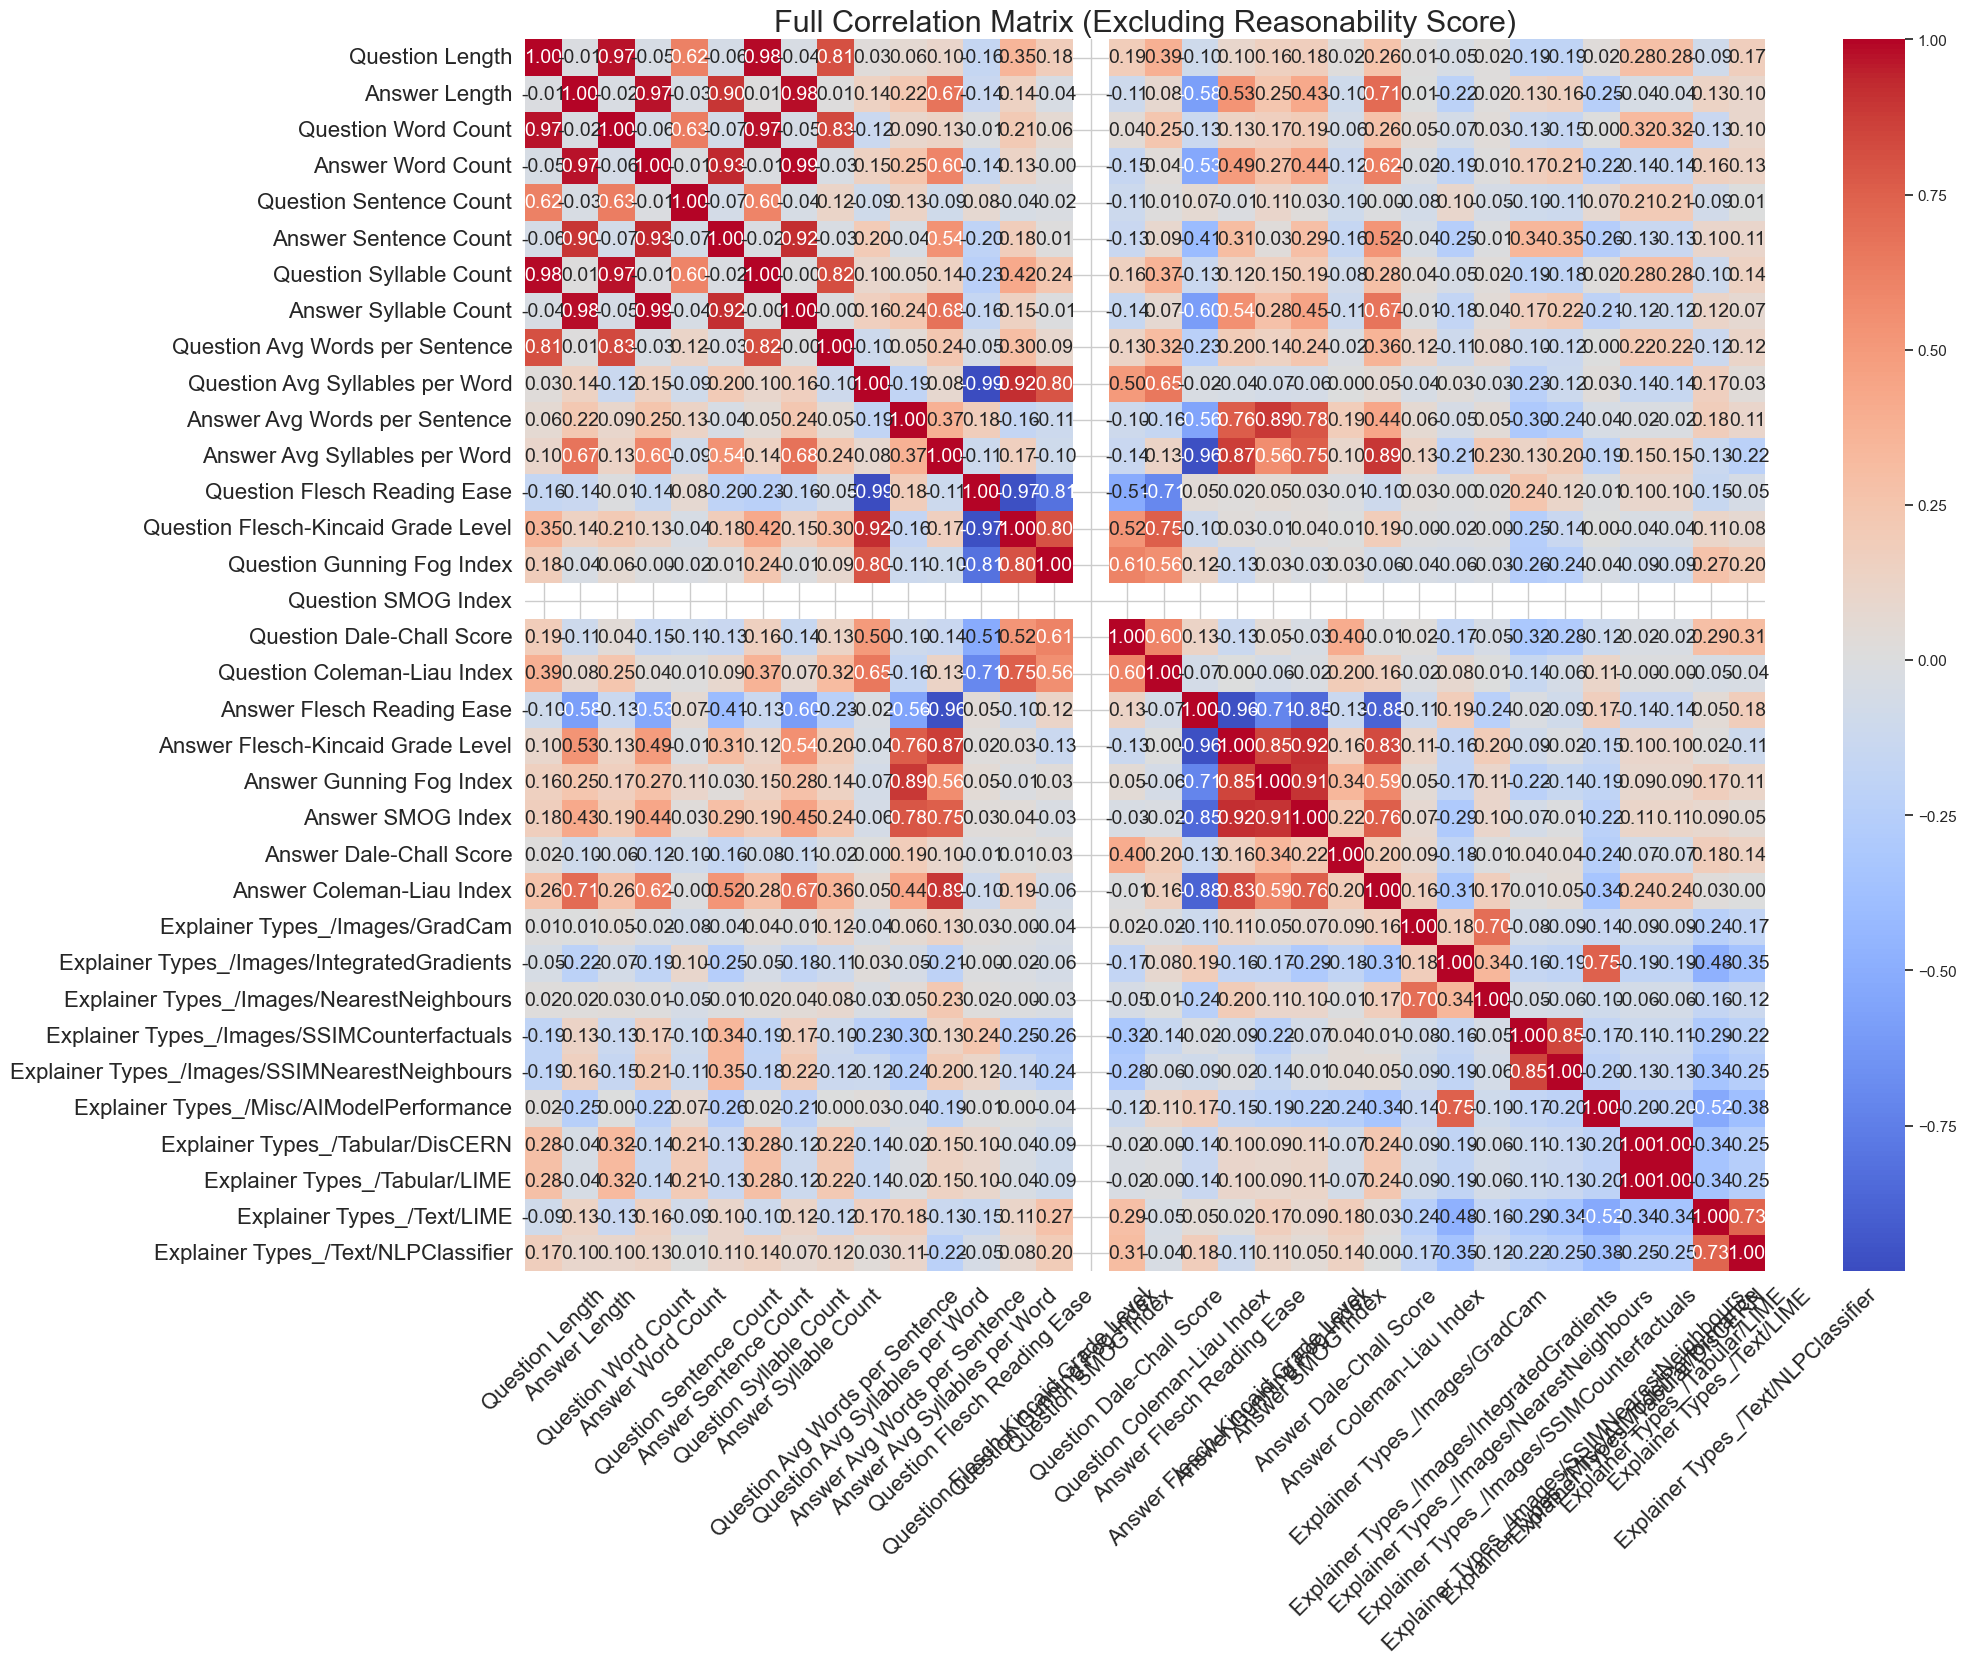




Full correlation matrix saved as: ./assets/full_correlation.png

Top 10 Correlations between Question and Answer Metrics:
                Question Metric                     Answer Metric  Correlation
      Question Dale-Chall Score           Answer Dale-Chall Score     0.403487
Question Avg Words per Sentence         Answer Coleman-Liau Index     0.356745
        Question Syllable Count         Answer Coleman-Liau Index     0.279693
            Question Word Count         Answer Coleman-Liau Index     0.264588
                Question Length         Answer Coleman-Liau Index     0.260989
Question Avg Words per Sentence                 Answer SMOG Index     0.240794
Question Avg Words per Sentence     Answer Avg Syllables per Word     0.235477
Question Avg Words per Sentence        Answer Flesch Reading Ease    -0.230675
Question Avg Syllables per Word             Answer Sentence Count     0.203400
Question Avg Words per Sentence Answer Flesch-Kincaid Grade Level     0.198451





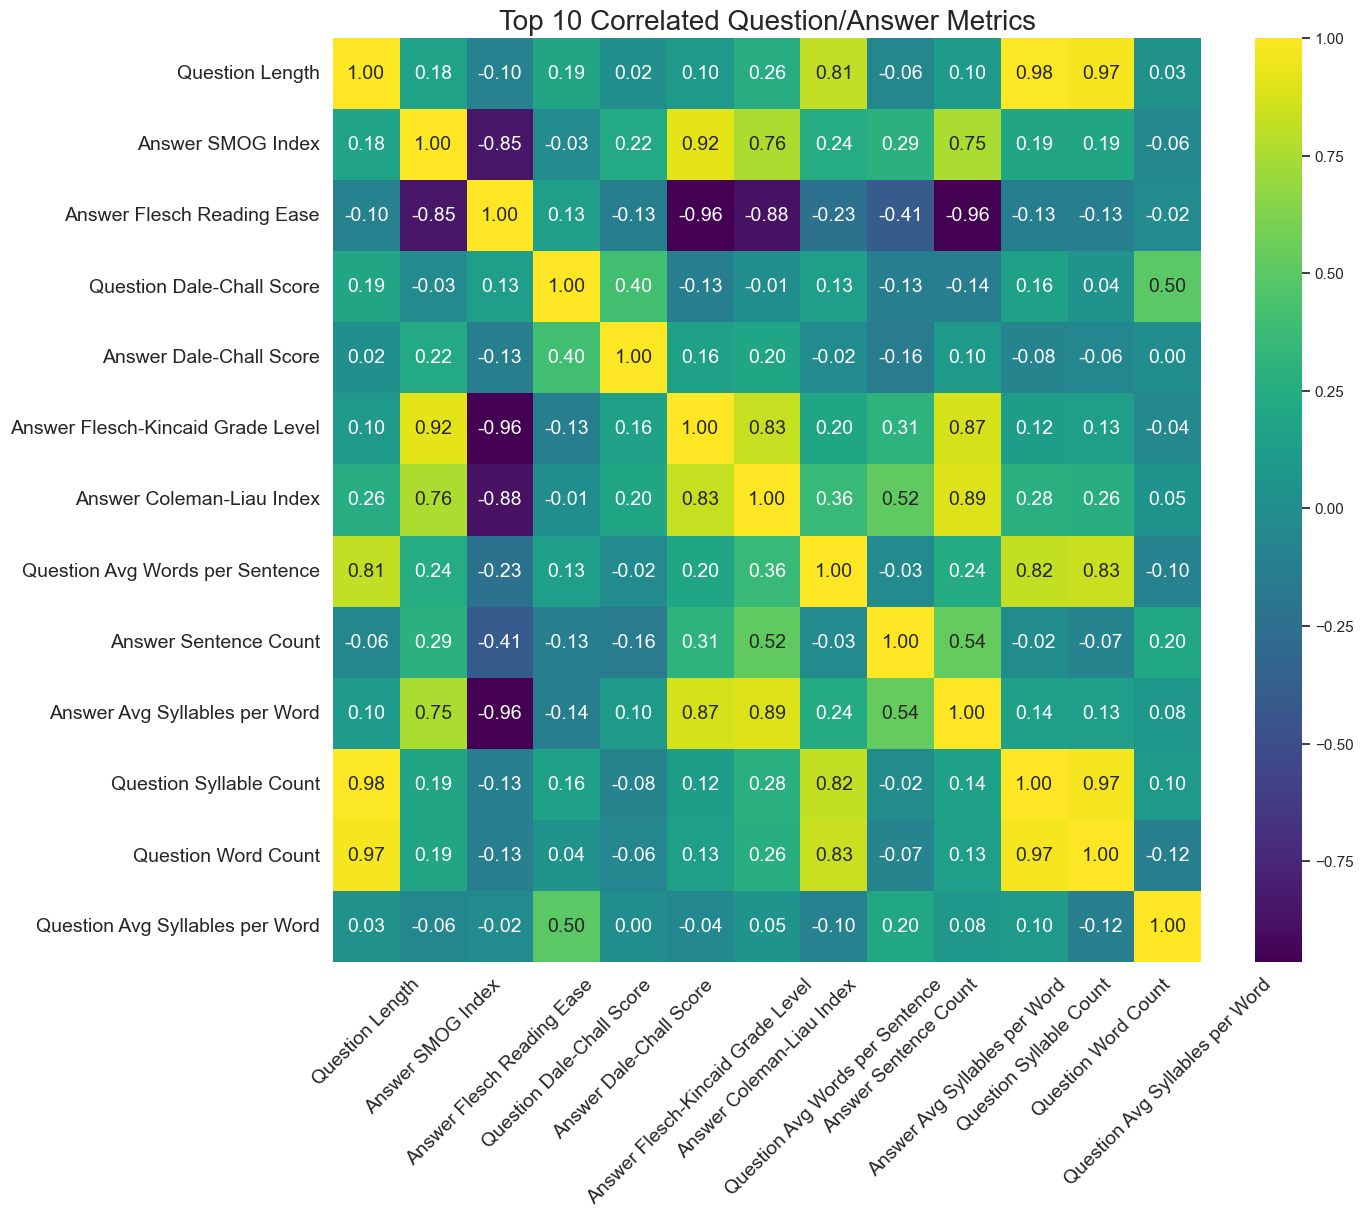

In [83]:
analyze_interaction_metrics(list(qa_interaction_data.values()))

## Cluster Analysis With Lexical Metrics

In [93]:
def cluster_interaction_analysis(data, cluster_range=(2, 10), random_state=42):
    """
    Performs clustering and user segmentation analysis on chat interactions.
    
    Each dictionary in the input list should contain:
      - "usecase_name": String (categorical)
      - "explainer_types": List of strings (e.g., ["Type A", "Visual"])
      - "question": String
      - "answer": String
      - "user_persona": String (categorical)
      - "reasonability_score": Integer between 1 and 10

    The function:
      - Computes various text metrics for both questions and answers.
      - Processes categorical fields (using MultiLabelBinarizer for explainer_types).
      - Standardizes numeric features.
      - Uses the elbow and silhouette methods to help determine the ideal number of clusters.
      - Generates interactive plots (using Plotly) for:
           • The elbow plot (inertia vs. k)
           • Silhouette scores vs. k
           • PCA scatter plots for each k in the tested range with annotations showing cluster counts.
           • For each k in the tested range, a bar chart displaying the distribution of user personas among clusters.
           • A PCA scatter plot for the ideal k clusters (with user persona symbols).
      - Saves all plots as HTML files inside an "assets" folder and also displays them inline.
      - Saves the final DataFrame (with assigned cluster labels for the ideal k) as a CSV file in the assets folder.
      
    This function does not return any value.
    """

    # Ensure the assets folder exists.
    assets_folder = "./assets/cluster_lexical/"
    os.makedirs(assets_folder, exist_ok=True)

    # -------------------- Compute Text Metrics --------------------
    results = []
    for interaction in data:
        usecase_name         = interaction.get("usecase_name", None)
        explainer_types      = interaction.get("explainer_types", [])  # expected list
        question             = interaction.get("question", "")
        answer               = interaction.get("answer", "")
        user_persona         = interaction.get("user_persona", None)
        
        metrics = {
            # Basic counts:
            "Question Length": len(question),
            "Answer Length": len(answer),
            "Question Word Count": textstat.lexicon_count(question, removepunct=True),
            "Answer Word Count": textstat.lexicon_count(answer, removepunct=True),
            "Question Sentence Count": textstat.sentence_count(question),
            "Answer Sentence Count": textstat.sentence_count(answer),
            "Question Syllable Count": textstat.syllable_count(question),
            "Answer Syllable Count": textstat.syllable_count(answer),
            
            # Averages:
            "Question Avg Words per Sentence": textstat.lexicon_count(question) / max(1, textstat.sentence_count(question)),
            "Question Avg Syllables per Word": textstat.syllable_count(question) / max(1, textstat.lexicon_count(question)),
            "Answer Avg Words per Sentence": textstat.lexicon_count(answer) / max(1, textstat.sentence_count(answer)),
            "Answer Avg Syllables per Word": textstat.syllable_count(answer) / max(1, textstat.lexicon_count(answer)),
            
           
            # Outcome and categoricals:
            "Usecase Name": usecase_name,
            "Explainer Types": explainer_types,  # keep as list for processing below
            "User Persona": user_persona,
        }
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # -------------------- Process "Explainer Types" --------------------
    if "Explainer Types" in df.columns and not df["Explainer Types"].isnull().all():
        sample_val = df["Explainer Types"].dropna().iloc[0]
        if isinstance(sample_val, list):
            mlb = MultiLabelBinarizer()
            explainer_dummies = pd.DataFrame(
                mlb.fit_transform(df["Explainer Types"]),
                columns=[f"Explainer Types_{cat}" for cat in mlb.classes_],
                index=df.index
            )
            df = pd.concat([df, explainer_dummies], axis=1)
            df.drop(columns=["Explainer Types"], inplace=True)
    
    # -------------------- Print Detailed Initial DataFrame --------------------
    # pd.set_option("display.max_columns", None)
    # pd.set_option("display.width", 250)
    # print("\n=== Interaction Analysis DataFrame ===")
    # print("Shape:", df.shape)
    # print(df.head(10).to_string(index=False))
    
    # -------------------- Prepare Data for Clustering --------------------
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    clustering_data = df[numeric_cols].copy()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clustering_data)
    
    # -------------------- Determine Ideal Number of Clusters --------------------
    ks = list(range(cluster_range[0], cluster_range[1] + 1))
    inertias = []
    silhouettes = []
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        if k > 1:
            sil_score = silhouette_score(X_scaled, labels)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(np.nan)
    
    # Interactive Elbow Plot using Plotly
    elbow_fig = go.Figure()
    elbow_fig.add_trace(go.Scatter(x=ks, y=inertias, mode='lines+markers', name='Inertia'))
    elbow_fig.update_layout(
        title="Elbow Plot: Inertia vs. Number of Clusters",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Inertia",
        font=dict(size=14)
    )
    elbow_output_path = os.path.join(assets_folder, "elbow_plot.html")
    elbow_fig.write_html(elbow_output_path)
    elbow_fig.show()
    print("Interactive Elbow Plot saved as:", elbow_output_path)
    
    # Interactive Silhouette Score Plot using Plotly
    sil_fig = go.Figure()
    sil_fig.add_trace(go.Scatter(x=ks, y=silhouettes, mode='lines+markers', name='Silhouette Score'))
    sil_fig.update_layout(
        title="Silhouette Score vs. Number of Clusters",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Silhouette Score",
        font=dict(size=14)
    )
    sil_output_path = os.path.join(assets_folder, "silhouette_plot.html")
    sil_fig.write_html(sil_output_path)
    sil_fig.show()
    print("Interactive Silhouette Plot saved as:", sil_output_path)
    
    # Choose ideal number of clusters based on maximum silhouette score (ignoring k=1)
    ideal_k_index = np.nanargmax(silhouettes[1:])  # index for k>=2
    ideal_k = ks[ideal_k_index + 1]
    print(f"Ideal number of clusters based on silhouette score: {ideal_k}")
    
    # -------------------- Generate Interactive PCA Scatter Plots for Each k with Cluster Distribution --------------------
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        
        pca = PCA(n_components=2, random_state=random_state)
        X_pca = pca.fit_transform(X_scaled)
        scatter_df = pd.DataFrame({
            "PCA_1": X_pca[:, 0],
            "PCA_2": X_pca[:, 1],
            "Cluster": labels.astype(str)
        })
        scatter_fig = px.scatter(
            scatter_df, x="PCA_1", y="PCA_2", color="Cluster",
            title=f"PCA Scatter Plot for k = {k} Clusters",
            hover_data=["Cluster"]
        )
        # Annotate with cluster distribution (user persona counts)
        # For this, get the distribution of "User Persona" within each cluster.
        temp_df = df.copy()
        temp_df["Cluster"] = labels.astype(str)
        seg_table = temp_df.groupby("User Persona")["Cluster"].value_counts().unstack(fill_value=0)
        # Build annotation text
        import collections
        counts = collections.Counter(labels)
        ordered_counts = sorted(counts.items())
        cluster_counts_text = "<br>".join([f"Cluster {cl}: {cnt}" for cl, cnt in ordered_counts])
        scatter_fig.add_annotation(
            xref="paper", yref="paper",
            x=0.98, y=0.98,
            text=f"<b>Overall Cluster Distribution:</b><br>{cluster_counts_text}",
            showarrow=False,
            bordercolor="black", borderwidth=1, bgcolor="white",
            font=dict(size=12),
            align="left"
        )
        scatter_output_path = os.path.join(assets_folder, f"cluster_scatter_{k}.html")
        scatter_fig.write_html(scatter_output_path)
        scatter_fig.show()
        print(f"Interactive PCA Scatter Plot for k={k} saved as:", scatter_output_path)
    
    # -------------------- Generate Interactive User Segmentation Bar Charts for Each k --------------------
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        temp_df = df.copy()
        temp_df["Cluster"] = labels.astype(str)
        seg_table = temp_df.groupby("User Persona")["Cluster"].value_counts().unstack(fill_value=0)
        seg_fig = px.bar(
            seg_table,
            barmode="stack",
            title=f"User Segmentation (Distribution of User Persona across Clusters) for k = {k}",
            labels={"value": "Count", "User Persona": "User Persona", "Cluster": "Cluster"}
        )
        seg_output_path = os.path.join(assets_folder, f"user_segmentation_k_{k}.html")
        seg_fig.write_html(seg_output_path)
        seg_fig.show()
        print(f"Interactive User Segmentation Bar Chart for k={k} saved as:", seg_output_path)
    
    # -------------------- Generate Interactive Plot for Ideal k Clusters --------------------
    kmeans_ideal = KMeans(n_clusters=ideal_k, random_state=random_state)
    ideal_labels = kmeans_ideal.fit_predict(X_scaled)
    pca = PCA(n_components=2, random_state=random_state)
    X_pca_ideal = pca.fit_transform(X_scaled)
    ideal_scatter_df = pd.DataFrame({
        "PCA_1": X_pca_ideal[:, 0],
        "PCA_2": X_pca_ideal[:, 1],
        "Cluster": ideal_labels.astype(str),
        "User Persona": df["User Persona"]
    })
    ideal_scatter_fig = px.scatter(
        ideal_scatter_df, x="PCA_1", y="PCA_2", color="Cluster",
        symbol="User Persona", 
        title=f"PCA Scatter Plot for Ideal k = {ideal_k} Clusters",
        hover_data=["User Persona", "Cluster"]
    )
    ideal_scatter_output_path = os.path.join(assets_folder, "ideal_cluster_scatter.html")
    ideal_scatter_fig.write_html(ideal_scatter_output_path)
    ideal_scatter_fig.show()
    print("Interactive PCA Scatter Plot for ideal clusters saved as:", ideal_scatter_output_path)
    
    # -------------------- Save Final Clustered Data (Ideal k) --------------------
    df["Ideal Cluster"] = ideal_labels
    final_data_path = os.path.join(assets_folder, "final_cluster_data.csv")
    df.to_csv(final_data_path, index=False)
    print("Final clustered data saved as:", final_data_path)
    

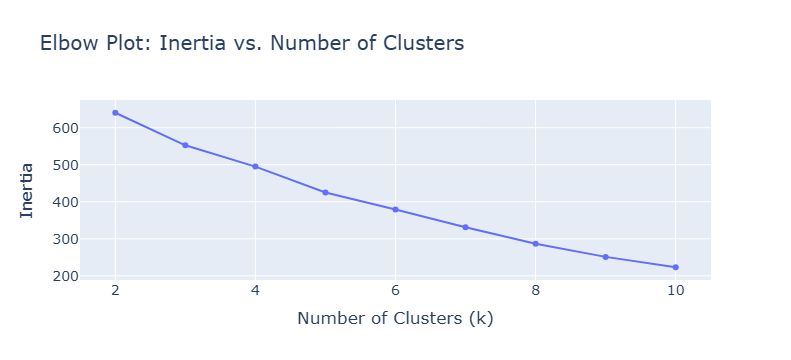

Interactive Elbow Plot saved as: ./assets/cluster_lexical/elbow_plot.html


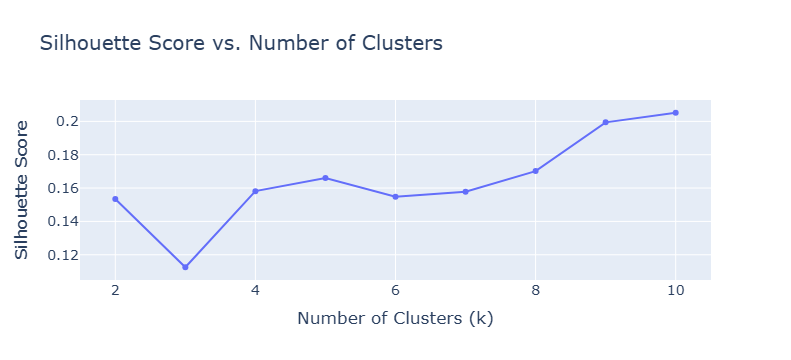

Interactive Silhouette Plot saved as: ./assets/cluster_lexical/silhouette_plot.html
Ideal number of clusters based on silhouette score: 10


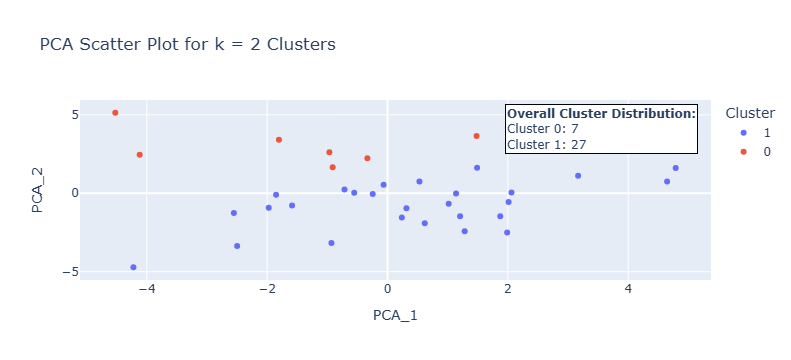

Interactive PCA Scatter Plot for k=2 saved as: ./assets/cluster_lexical/cluster_scatter_2.html


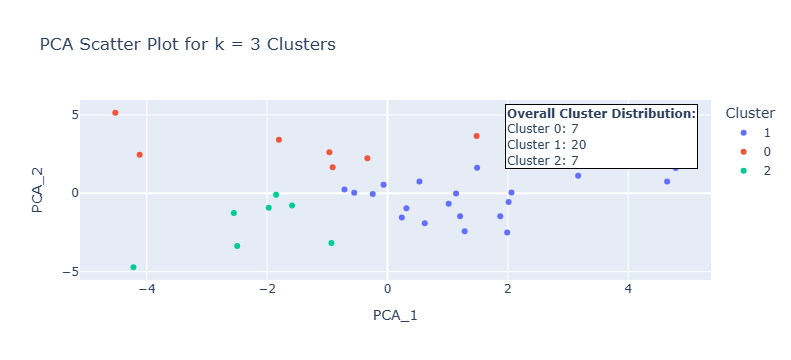

Interactive PCA Scatter Plot for k=3 saved as: ./assets/cluster_lexical/cluster_scatter_3.html


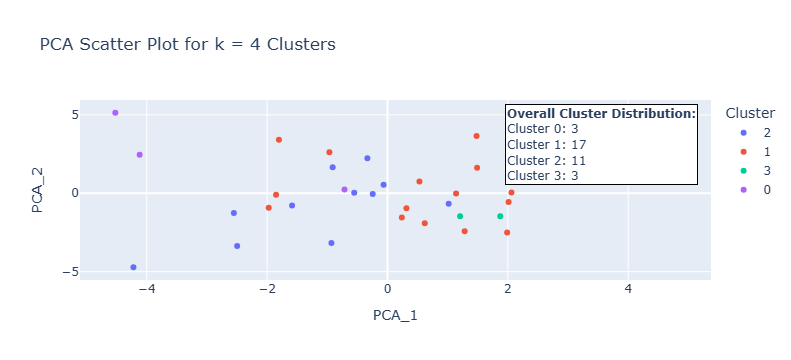

Interactive PCA Scatter Plot for k=4 saved as: ./assets/cluster_lexical/cluster_scatter_4.html


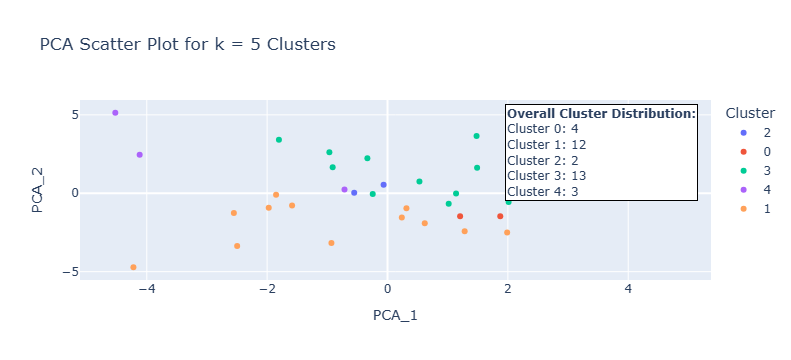

Interactive PCA Scatter Plot for k=5 saved as: ./assets/cluster_lexical/cluster_scatter_5.html


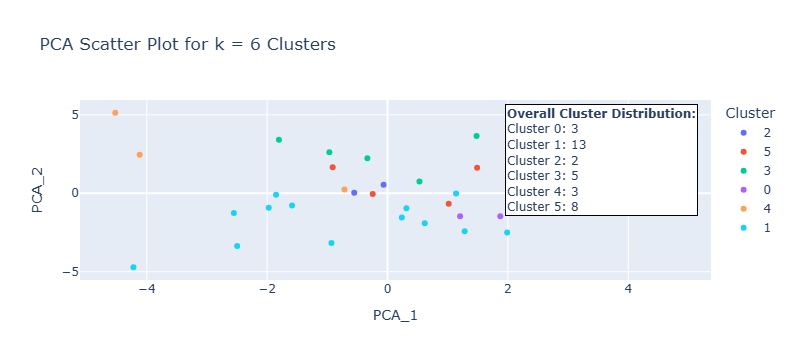

Interactive PCA Scatter Plot for k=6 saved as: ./assets/cluster_lexical/cluster_scatter_6.html


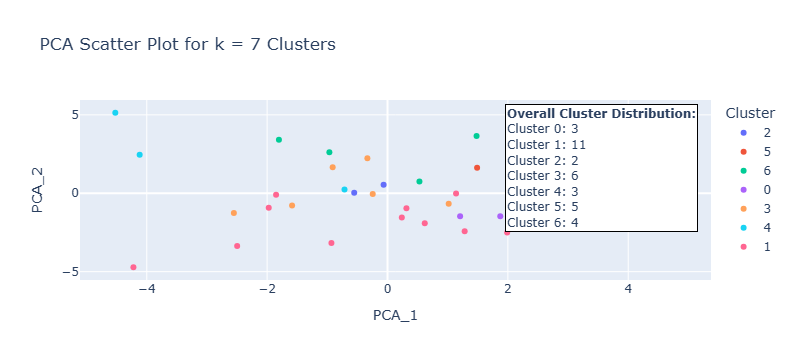

Interactive PCA Scatter Plot for k=7 saved as: ./assets/cluster_lexical/cluster_scatter_7.html


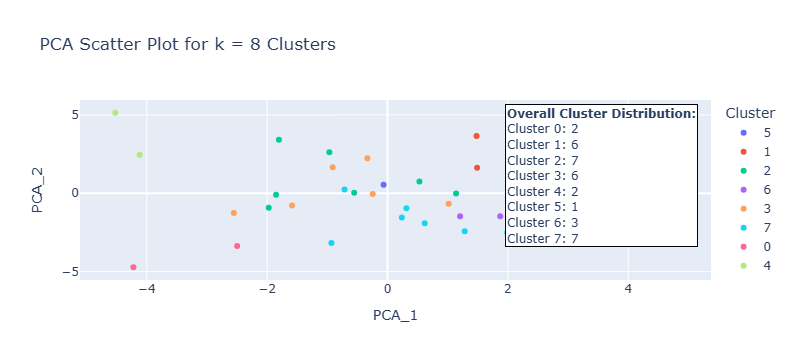

Interactive PCA Scatter Plot for k=8 saved as: ./assets/cluster_lexical/cluster_scatter_8.html


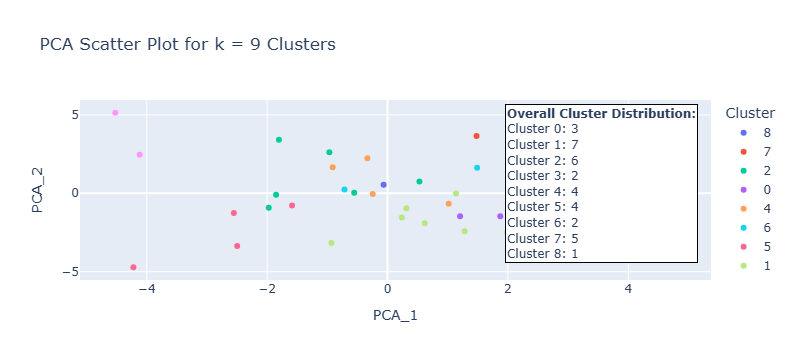

Interactive PCA Scatter Plot for k=9 saved as: ./assets/cluster_lexical/cluster_scatter_9.html


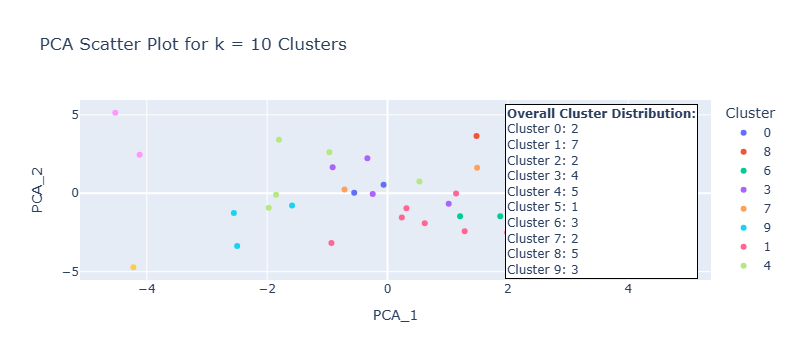

Interactive PCA Scatter Plot for k=10 saved as: ./assets/cluster_lexical/cluster_scatter_10.html


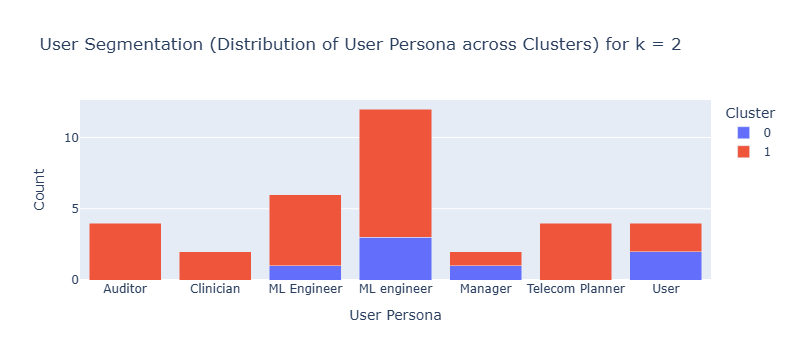

Interactive User Segmentation Bar Chart for k=2 saved as: ./assets/cluster_lexical/user_segmentation_k_2.html


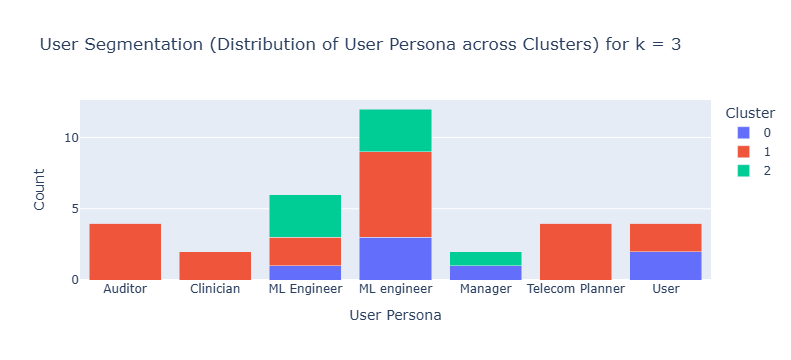

Interactive User Segmentation Bar Chart for k=3 saved as: ./assets/cluster_lexical/user_segmentation_k_3.html


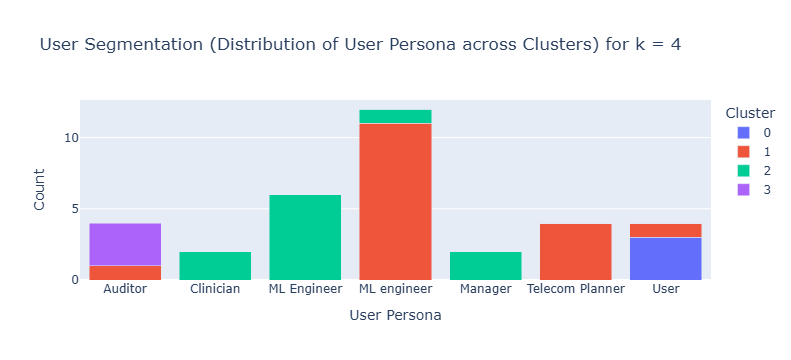

Interactive User Segmentation Bar Chart for k=4 saved as: ./assets/cluster_lexical/user_segmentation_k_4.html


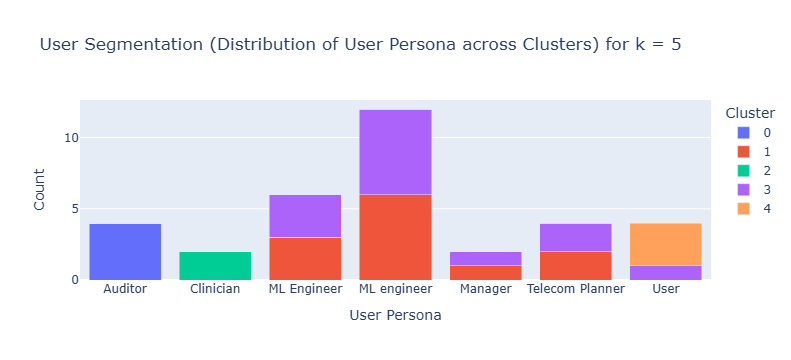

Interactive User Segmentation Bar Chart for k=5 saved as: ./assets/cluster_lexical/user_segmentation_k_5.html


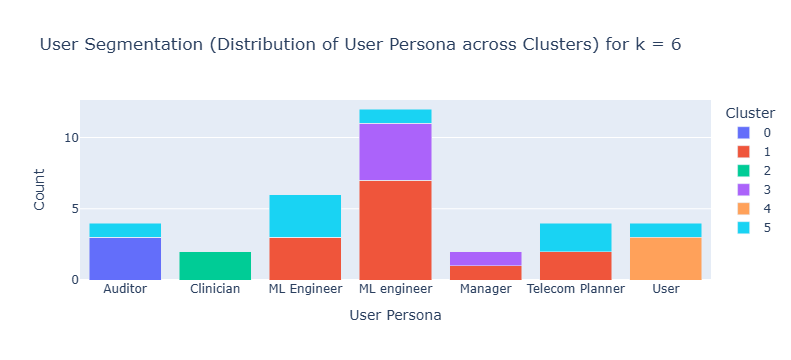

Interactive User Segmentation Bar Chart for k=6 saved as: ./assets/cluster_lexical/user_segmentation_k_6.html


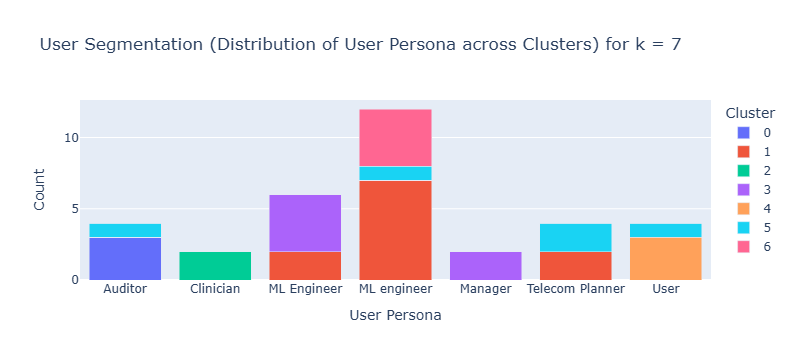

Interactive User Segmentation Bar Chart for k=7 saved as: ./assets/cluster_lexical/user_segmentation_k_7.html


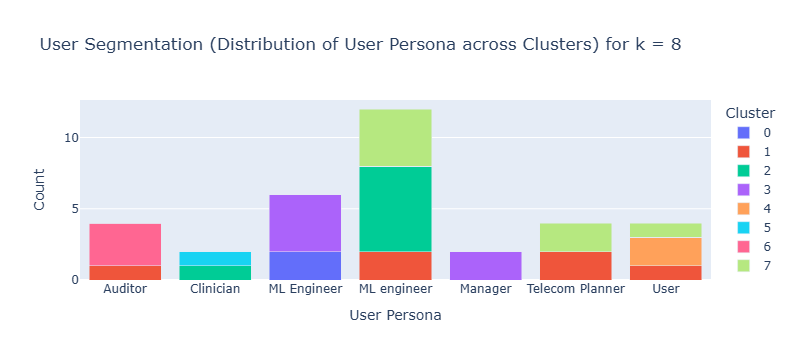

Interactive User Segmentation Bar Chart for k=8 saved as: ./assets/cluster_lexical/user_segmentation_k_8.html


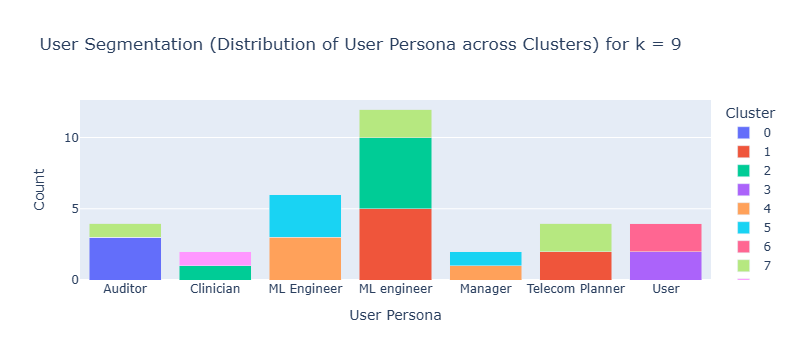

Interactive User Segmentation Bar Chart for k=9 saved as: ./assets/cluster_lexical/user_segmentation_k_9.html


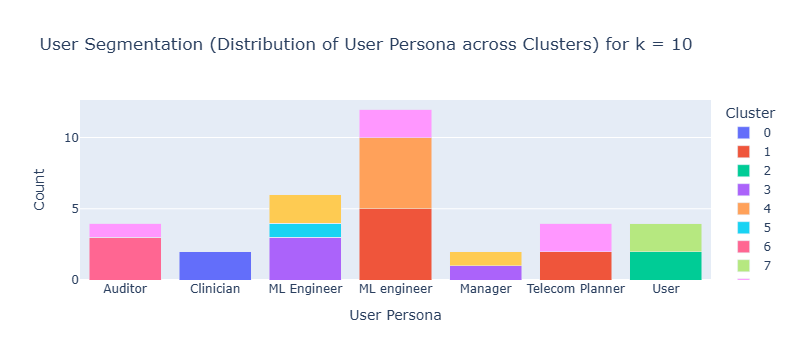

Interactive User Segmentation Bar Chart for k=10 saved as: ./assets/cluster_lexical/user_segmentation_k_10.html


Interactive PCA Scatter Plot for ideal clusters saved as: ./assets/cluster_lexical/ideal_cluster_scatter.html
Final clustered data saved as: ./assets/cluster_lexical/final_cluster_data.csv


In [94]:
cluster_interaction_analysis(list(qa_interaction_data.values()))

## Cluster Analysis With Lexical & Readability Metrics

In [95]:
def cluster_interaction_analysis(data, cluster_range=(2, 10), random_state=42):
    """
    Performs clustering and user segmentation analysis on chat interactions.
    
    Each dictionary in the input list should contain:
      - "usecase_name": String (categorical)
      - "explainer_types": List of strings (e.g., ["Type A", "Visual"])
      - "question": String
      - "answer": String
      - "user_persona": String (categorical)
      - "reasonability_score": Integer between 1 and 10

    The function:
      - Computes various text metrics for both questions and answers.
      - Processes categorical fields (using MultiLabelBinarizer for explainer_types).
      - Standardizes numeric features.
      - Uses the elbow and silhouette methods to help determine the ideal number of clusters.
      - Generates interactive plots (using Plotly) for:
           • The elbow plot (inertia vs. k)
           • Silhouette scores vs. k
           • PCA scatter plots for each k in the tested range with annotations showing cluster counts.
           • For each k in the tested range, a bar chart displaying the distribution of user personas among clusters.
           • A PCA scatter plot for the ideal k clusters (with user persona symbols).
      - Saves all plots as HTML files inside an "assets" folder and also displays them inline.
      - Saves the final DataFrame (with assigned cluster labels for the ideal k) as a CSV file in the assets folder.
      
    This function does not return any value.
    """

    # Ensure the assets folder exists.
    assets_folder = "./assets/cluster_lexical_readability/"
    os.makedirs(assets_folder, exist_ok=True)

    # -------------------- Compute Text Metrics --------------------
    results = []
    for interaction in data:
        usecase_name         = interaction.get("usecase_name", None)
        explainer_types      = interaction.get("explainer_types", [])  # expected list
        question             = interaction.get("question", "")
        answer               = interaction.get("answer", "")
        user_persona         = interaction.get("user_persona", None)
        
        metrics = {
            # Basic counts:
            "Question Length": len(question),
            "Answer Length": len(answer),
            "Question Word Count": textstat.lexicon_count(question, removepunct=True),
            "Answer Word Count": textstat.lexicon_count(answer, removepunct=True),
            "Question Sentence Count": textstat.sentence_count(question),
            "Answer Sentence Count": textstat.sentence_count(answer),
            "Question Syllable Count": textstat.syllable_count(question),
            "Answer Syllable Count": textstat.syllable_count(answer),
            
            # Averages:
            "Question Avg Words per Sentence": textstat.lexicon_count(question) / max(1, textstat.sentence_count(question)),
            "Question Avg Syllables per Word": textstat.syllable_count(question) / max(1, textstat.lexicon_count(question)),
            "Answer Avg Words per Sentence": textstat.lexicon_count(answer) / max(1, textstat.sentence_count(answer)),
            "Answer Avg Syllables per Word": textstat.syllable_count(answer) / max(1, textstat.lexicon_count(answer)),
            
            # Readability for question:
            "Question Flesch Reading Ease": textstat.flesch_reading_ease(question),
            "Question Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(question),
            "Question Gunning Fog Index": textstat.gunning_fog(question),
            "Question SMOG Index": textstat.smog_index(question),
            "Question Dale-Chall Score": textstat.dale_chall_readability_score(question),
            "Question Coleman-Liau Index": textstat.coleman_liau_index(question),
            
            # Readability for answer:
            "Answer Flesch Reading Ease": textstat.flesch_reading_ease(answer),
            "Answer Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(answer),
            "Answer Gunning Fog Index": textstat.gunning_fog(answer),
            "Answer SMOG Index": textstat.smog_index(answer),
            "Answer Dale-Chall Score": textstat.dale_chall_readability_score(answer),
            "Answer Coleman-Liau Index": textstat.coleman_liau_index(answer),
            
            # Outcome and categoricals:
            "Usecase Name": usecase_name,
            "Explainer Types": explainer_types,  # keep as list for processing below
            "User Persona": user_persona,
        }
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # -------------------- Process "Explainer Types" --------------------
    if "Explainer Types" in df.columns and not df["Explainer Types"].isnull().all():
        sample_val = df["Explainer Types"].dropna().iloc[0]
        if isinstance(sample_val, list):
            mlb = MultiLabelBinarizer()
            explainer_dummies = pd.DataFrame(
                mlb.fit_transform(df["Explainer Types"]),
                columns=[f"Explainer Types_{cat}" for cat in mlb.classes_],
                index=df.index
            )
            df = pd.concat([df, explainer_dummies], axis=1)
            df.drop(columns=["Explainer Types"], inplace=True)
    
    # -------------------- Print Detailed Initial DataFrame --------------------
    # pd.set_option("display.max_columns", None)
    # pd.set_option("display.width", 250)
    # print("\n=== Interaction Analysis DataFrame ===")
    # print("Shape:", df.shape)
    # print(df.head(10).to_string(index=False))
    
    # -------------------- Prepare Data for Clustering --------------------
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    clustering_data = df[numeric_cols].copy()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clustering_data)
    
    # -------------------- Determine Ideal Number of Clusters --------------------
    ks = list(range(cluster_range[0], cluster_range[1] + 1))
    inertias = []
    silhouettes = []
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        if k > 1:
            sil_score = silhouette_score(X_scaled, labels)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(np.nan)
    
    # Interactive Elbow Plot using Plotly
    elbow_fig = go.Figure()
    elbow_fig.add_trace(go.Scatter(x=ks, y=inertias, mode='lines+markers', name='Inertia'))
    elbow_fig.update_layout(
        title="Elbow Plot: Inertia vs. Number of Clusters",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Inertia",
        font=dict(size=14)
    )
    elbow_output_path = os.path.join(assets_folder, "elbow_plot.html")
    elbow_fig.write_html(elbow_output_path)
    elbow_fig.show()
    print("Interactive Elbow Plot saved as:", elbow_output_path)
    
    # Interactive Silhouette Score Plot using Plotly
    sil_fig = go.Figure()
    sil_fig.add_trace(go.Scatter(x=ks, y=silhouettes, mode='lines+markers', name='Silhouette Score'))
    sil_fig.update_layout(
        title="Silhouette Score vs. Number of Clusters",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Silhouette Score",
        font=dict(size=14)
    )
    sil_output_path = os.path.join(assets_folder, "silhouette_plot.html")
    sil_fig.write_html(sil_output_path)
    sil_fig.show()
    print("Interactive Silhouette Plot saved as:", sil_output_path)
    
    # Choose ideal number of clusters based on maximum silhouette score (ignoring k=1)
    ideal_k_index = np.nanargmax(silhouettes[1:])  # index for k>=2
    ideal_k = ks[ideal_k_index + 1]
    print(f"Ideal number of clusters based on silhouette score: {ideal_k}")
    
    # -------------------- Generate Interactive PCA Scatter Plots for Each k with Cluster Distribution --------------------
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        
        pca = PCA(n_components=2, random_state=random_state)
        X_pca = pca.fit_transform(X_scaled)
        scatter_df = pd.DataFrame({
            "PCA_1": X_pca[:, 0],
            "PCA_2": X_pca[:, 1],
            "Cluster": labels.astype(str)
        })
        scatter_fig = px.scatter(
            scatter_df, x="PCA_1", y="PCA_2", color="Cluster",
            title=f"PCA Scatter Plot for k = {k} Clusters",
            hover_data=["Cluster"]
        )
        # Annotate with cluster distribution (user persona counts)
        # For this, get the distribution of "User Persona" within each cluster.
        temp_df = df.copy()
        temp_df["Cluster"] = labels.astype(str)
        seg_table = temp_df.groupby("User Persona")["Cluster"].value_counts().unstack(fill_value=0)
        # Build annotation text
        import collections
        counts = collections.Counter(labels)
        ordered_counts = sorted(counts.items())
        cluster_counts_text = "<br>".join([f"Cluster {cl}: {cnt}" for cl, cnt in ordered_counts])
        scatter_fig.add_annotation(
            xref="paper", yref="paper",
            x=0.98, y=0.98,
            text=f"<b>Overall Cluster Distribution:</b><br>{cluster_counts_text}",
            showarrow=False,
            bordercolor="black", borderwidth=1, bgcolor="white",
            font=dict(size=12),
            align="left"
        )
        scatter_output_path = os.path.join(assets_folder, f"cluster_scatter_{k}.html")
        scatter_fig.write_html(scatter_output_path)
        scatter_fig.show()
        print(f"Interactive PCA Scatter Plot for k={k} saved as:", scatter_output_path)
    
    # -------------------- Generate Interactive User Segmentation Bar Charts for Each k --------------------
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        temp_df = df.copy()
        temp_df["Cluster"] = labels.astype(str)
        seg_table = temp_df.groupby("User Persona")["Cluster"].value_counts().unstack(fill_value=0)
        seg_fig = px.bar(
            seg_table,
            barmode="stack",
            title=f"User Segmentation (Distribution of User Persona across Clusters) for k = {k}",
            labels={"value": "Count", "User Persona": "User Persona", "Cluster": "Cluster"}
        )
        seg_output_path = os.path.join(assets_folder, f"user_segmentation_k_{k}.html")
        seg_fig.write_html(seg_output_path)
        seg_fig.show()
        print(f"Interactive User Segmentation Bar Chart for k={k} saved as:", seg_output_path)
    
    # -------------------- Generate Interactive Plot for Ideal k Clusters --------------------
    kmeans_ideal = KMeans(n_clusters=ideal_k, random_state=random_state)
    ideal_labels = kmeans_ideal.fit_predict(X_scaled)
    pca = PCA(n_components=2, random_state=random_state)
    X_pca_ideal = pca.fit_transform(X_scaled)
    ideal_scatter_df = pd.DataFrame({
        "PCA_1": X_pca_ideal[:, 0],
        "PCA_2": X_pca_ideal[:, 1],
        "Cluster": ideal_labels.astype(str),
        "User Persona": df["User Persona"]
    })
    ideal_scatter_fig = px.scatter(
        ideal_scatter_df, x="PCA_1", y="PCA_2", color="Cluster",
        symbol="User Persona", 
        title=f"PCA Scatter Plot for Ideal k = {ideal_k} Clusters",
        hover_data=["User Persona", "Cluster"]
    )
    ideal_scatter_output_path = os.path.join(assets_folder, "ideal_cluster_scatter.html")
    ideal_scatter_fig.write_html(ideal_scatter_output_path)
    ideal_scatter_fig.show()
    print("Interactive PCA Scatter Plot for ideal clusters saved as:", ideal_scatter_output_path)
    
    # -------------------- Save Final Clustered Data (Ideal k) --------------------
    df["Ideal Cluster"] = ideal_labels
    final_data_path = os.path.join(assets_folder, "final_cluster_data.csv")
    df.to_csv(final_data_path, index=False)
    print("Final clustered data saved as:", final_data_path)
    

In [96]:
cluster_interaction_analysis(list(qa_interaction_data.values()))

Interactive Elbow Plot saved as: ./assets/cluster_lexical_readability/elbow_plot.html


Interactive Silhouette Plot saved as: ./assets/cluster_lexical_readability/silhouette_plot.html
Ideal number of clusters based on silhouette score: 9


Interactive PCA Scatter Plot for k=2 saved as: ./assets/cluster_lexical_readability/cluster_scatter_2.html


Interactive PCA Scatter Plot for k=3 saved as: ./assets/cluster_lexical_readability/cluster_scatter_3.html


Interactive PCA Scatter Plot for k=4 saved as: ./assets/cluster_lexical_readability/cluster_scatter_4.html


Interactive PCA Scatter Plot for k=5 saved as: ./assets/cluster_lexical_readability/cluster_scatter_5.html


Interactive PCA Scatter Plot for k=6 saved as: ./assets/cluster_lexical_readability/cluster_scatter_6.html


Interactive PCA Scatter Plot for k=7 saved as: ./assets/cluster_lexical_readability/cluster_scatter_7.html


Interactive PCA Scatter Plot for k=8 saved as: ./assets/cluster_lexical_readability/cluster_scatter_8.html


Interactive PCA Scatter Plot for k=9 saved as: ./assets/cluster_lexical_readability/cluster_scatter_9.html


Interactive PCA Scatter Plot for k=10 saved as: ./assets/cluster_lexical_readability/cluster_scatter_10.html


Interactive User Segmentation Bar Chart for k=2 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_2.html


Interactive User Segmentation Bar Chart for k=3 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_3.html


Interactive User Segmentation Bar Chart for k=4 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_4.html


Interactive User Segmentation Bar Chart for k=5 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_5.html


Interactive User Segmentation Bar Chart for k=6 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_6.html


Interactive User Segmentation Bar Chart for k=7 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_7.html


Interactive User Segmentation Bar Chart for k=8 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_8.html


Interactive User Segmentation Bar Chart for k=9 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_9.html


Interactive User Segmentation Bar Chart for k=10 saved as: ./assets/cluster_lexical_readability/user_segmentation_k_10.html


Interactive PCA Scatter Plot for ideal clusters saved as: ./assets/cluster_lexical_readability/ideal_cluster_scatter.html
Final clustered data saved as: ./assets/cluster_lexical_readability/final_cluster_data.csv


## Cluster Analysis With Question Based Embeddings

In [98]:
def cluster_interaction_analysis(data, question_emb, cluster_range=(2, 10), random_state=42):
    """
    Performs clustering and user segmentation analysis on chat interactions using embedding vectors.
    
    Each dictionary in the input list (data) should contain:
      - "usecase_name": String (categorical)
      - "explainer_types": List of strings (e.g., ["Type A", "Visual"])
      - "question": String
      - "answer": String
      - "user_persona": String (categorical)
      - "reasonability_score": Integer between 1 and 10

    Additionally, a separate dictionary (question_emb) should provide an embedding vector for each question.
    
    The function:
      - For each interaction, retrieves the "embedding" from the question_emb dict and adds it as a new attribute.
      - Processes categorical fields (using MultiLabelBinarizer for explainer_types).
      - Uses only the embedding vectors (standardized) for clustering.
      - Uses the elbow and silhouette methods to help determine the ideal number of clusters.
      - Generates interactive plots (using Plotly) for:
           • The elbow plot (inertia vs. k)
           • Silhouette scores vs. k
           • PCA scatter plots for each k in the tested range with annotations showing cluster counts.
           • For each k in the tested range, a bar chart displaying the distribution of user personas among clusters.
           • A PCA scatter plot for the ideal k clusters (with user persona symbols).
      - Saves all plots as HTML files inside an "assets" folder and also displays them inline.
      - Saves the final DataFrame (with assigned cluster labels for the ideal k) as a CSV file in the assets folder.
      
    This function does not return any value.
    """
    # Ensure the assets folder exists.
    assets_folder = "./assets/cluster_semantic/"
    os.makedirs(assets_folder, exist_ok=True)
    
    # -------------------- Build DataFrame with Embeddings --------------------
    # For each interaction, retrieve its embedding from question_emb and keep other attributes.
    results = []
    for interaction in data:
        question_text = interaction.get("question", "")
        emb = question_emb.get(question_text, None)
        if emb is None:
            raise ValueError(f"No Embeddings Found for {question_text}")
            continue
        metrics = {
            "Usecase Name": interaction.get("usecase_name", None),
            "User Persona": interaction.get("user_persona", None),
            "Reasonability Score": interaction.get("reasonability_score", np.nan),
            "Question": question_text,
            "Answer": interaction.get("answer", ""),
            "Explainer Types": interaction.get("explainer_types", []),
            "embedding": emb  # This should be a numeric vector (list or array)
        }
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # -------------------- Process "Explainer Types" --------------------
    if "Explainer Types" in df.columns and not df["Explainer Types"].isnull().all():
        sample_val = df["Explainer Types"].dropna().iloc[0]
        if isinstance(sample_val, list):
            mlb = MultiLabelBinarizer()
            explainer_dummies = pd.DataFrame(
                mlb.fit_transform(df["Explainer Types"]),
                columns=[f"Explainer Types_{cat}" for cat in mlb.classes_],
                index=df.index
            )
            df = pd.concat([df, explainer_dummies], axis=1)
            df.drop(columns=["Explainer Types"], inplace=True)
    
    # -------------------- Print Detailed Initial DataFrame --------------------
    # pd.set_option("display.max_columns", None)
    # pd.set_option("display.width", 250)
    # print("\n=== Interaction Analysis DataFrame (Using Embeddings) ===")
    # print("Shape:", df.shape)
    # print(df.head(10).to_string(index=False))
    
    # -------------------- Prepare Embedding Data for Clustering --------------------
    # Assume each "embedding" is a list/array of numbers.
    X = np.vstack(df["embedding"].values)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # -------------------- Determine Ideal Number of Clusters --------------------
    ks = list(range(cluster_range[0], cluster_range[1] + 1))
    inertias = []
    silhouettes = []
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        if k > 1:
            sil_score = silhouette_score(X_scaled, labels)
            silhouettes.append(sil_score)
        else:
            silhouettes.append(np.nan)
    
    # Interactive Elbow Plot using Plotly
    elbow_fig = go.Figure()
    elbow_fig.add_trace(go.Scatter(x=ks, y=inertias, mode='lines+markers', name='Inertia'))
    elbow_fig.update_layout(
        title="Elbow Plot: Inertia vs. Number of Clusters",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Inertia",
        font=dict(size=14)
    )
    elbow_output_path = os.path.join(assets_folder, "elbow_plot.html")
    elbow_fig.write_html(elbow_output_path)
    elbow_fig.show()
    print("Interactive Elbow Plot saved as:", elbow_output_path)
    
    # Interactive Silhouette Score Plot using Plotly
    sil_fig = go.Figure()
    sil_fig.add_trace(go.Scatter(x=ks, y=silhouettes, mode='lines+markers', name='Silhouette Score'))
    sil_fig.update_layout(
        title="Silhouette Score vs. Number of Clusters",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Silhouette Score",
        font=dict(size=14)
    )
    sil_output_path = os.path.join(assets_folder, "silhouette_plot.html")
    sil_fig.write_html(sil_output_path)
    sil_fig.show()
    print("Interactive Silhouette Plot saved as:", sil_output_path)
    
    # Choose ideal number of clusters based on maximum silhouette score (ignoring k=1)
    ideal_k_index = np.nanargmax(silhouettes[1:])  # index for k>=2
    ideal_k = ks[ideal_k_index + 1]
    print(f"Ideal number of clusters based on silhouette score: {ideal_k}")
    
    # -------------------- Generate Interactive PCA Scatter Plots for Each k with Cluster Distribution --------------------
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        
        pca = PCA(n_components=2, random_state=random_state)
        X_pca = pca.fit_transform(X_scaled)
        scatter_df = pd.DataFrame({
            "PCA_1": X_pca[:, 0],
            "PCA_2": X_pca[:, 1],
            "Cluster": labels.astype(str)
        })
        scatter_fig = px.scatter(
            scatter_df, x="PCA_1", y="PCA_2", color="Cluster",
            title=f"PCA Scatter Plot for k = {k} Clusters",
            hover_data=["Cluster"]
        )
        # Annotate with cluster distribution (user persona counts)
        temp_df = df.copy()
        temp_df["Cluster"] = labels.astype(str)
        import collections
        counts = collections.Counter(labels)
        ordered_counts = sorted(counts.items())
        cluster_counts_text = "<br>".join([f"Cluster {cl}: {cnt}" for cl, cnt in ordered_counts])
        scatter_fig.add_annotation(
            xref="paper", yref="paper",
            x=0.98, y=0.98,
            text=f"<b>Overall Cluster Distribution:</b><br>{cluster_counts_text}",
            showarrow=False,
            bordercolor="black", borderwidth=1, bgcolor="white",
            font=dict(size=12),
            align="left"
        )
        scatter_output_path = os.path.join(assets_folder, f"cluster_scatter_{k}.html")
        scatter_fig.write_html(scatter_output_path)
        scatter_fig.show()
        print(f"Interactive PCA Scatter Plot for k={k} saved as:", scatter_output_path)
    
    # -------------------- Generate Interactive User Segmentation Bar Charts for Each k --------------------
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        temp_df = df.copy()
        temp_df["Cluster"] = labels.astype(str)
        seg_table = temp_df.groupby("User Persona")["Cluster"].value_counts().unstack(fill_value=0)
        seg_fig = px.bar(
            seg_table,
            barmode="stack",
            title=f"User Segmentation (Distribution of User Persona across Clusters) for k = {k}",
            labels={"value": "Count", "User Persona": "User Persona", "Cluster": "Cluster"}
        )
        seg_output_path = os.path.join(assets_folder, f"user_segmentation_k_{k}.html")
        seg_fig.write_html(seg_output_path)
        seg_fig.show()
        print(f"Interactive User Segmentation Bar Chart for k={k} saved as:", seg_output_path)
    
    # -------------------- Generate Interactive Plot for Ideal k Clusters --------------------
    kmeans_ideal = KMeans(n_clusters=ideal_k, random_state=random_state)
    ideal_labels = kmeans_ideal.fit_predict(X_scaled)
    pca = PCA(n_components=2, random_state=random_state)
    X_pca_ideal = pca.fit_transform(X_scaled)
    ideal_scatter_df = pd.DataFrame({
        "PCA_1": X_pca_ideal[:, 0],
        "PCA_2": X_pca_ideal[:, 1],
        "Cluster": ideal_labels.astype(str),
        "User Persona": df["User Persona"]
    })
    ideal_scatter_fig = px.scatter(
        ideal_scatter_df, x="PCA_1", y="PCA_2", color="Cluster",
        symbol="User Persona", 
        title=f"PCA Scatter Plot for Ideal k = {ideal_k} Clusters",
        hover_data=["User Persona", "Cluster"]
    )
    ideal_scatter_output_path = os.path.join(assets_folder, "ideal_cluster_scatter.html")
    ideal_scatter_fig.write_html(ideal_scatter_output_path)
    ideal_scatter_fig.show()
    print("Interactive PCA Scatter Plot for ideal clusters saved as:", ideal_scatter_output_path)
    
    # -------------------- Save Final Clustered Data (Ideal k) --------------------
    df["Ideal Cluster"] = ideal_labels
    final_data_path = os.path.join(assets_folder, "final_cluster_data.csv")
    df.to_csv(final_data_path, index=False)
    print("Final clustered data saved as:", final_data_path)


In [108]:
with open("./data/question_emb_dict.json", "r") as f:
    question_emb_dict = json.load(f)

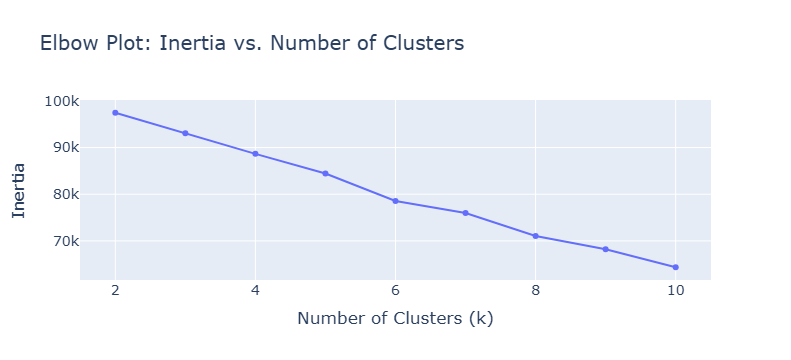

Interactive Elbow Plot saved as: ./assets/cluster_semantic/elbow_plot.html


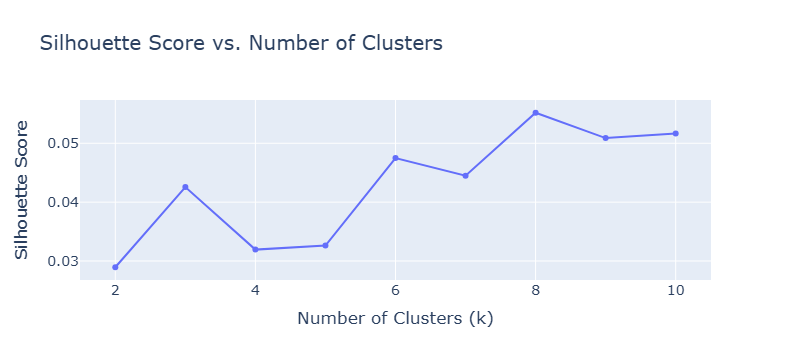

Interactive Silhouette Plot saved as: ./assets/cluster_semantic/silhouette_plot.html
Ideal number of clusters based on silhouette score: 8


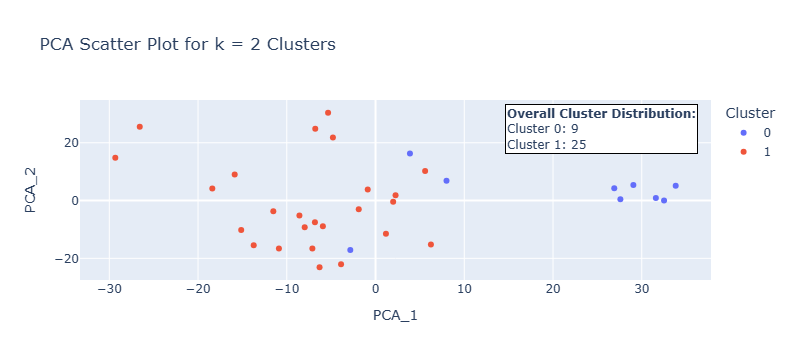

Interactive PCA Scatter Plot for k=2 saved as: ./assets/cluster_semantic/cluster_scatter_2.html


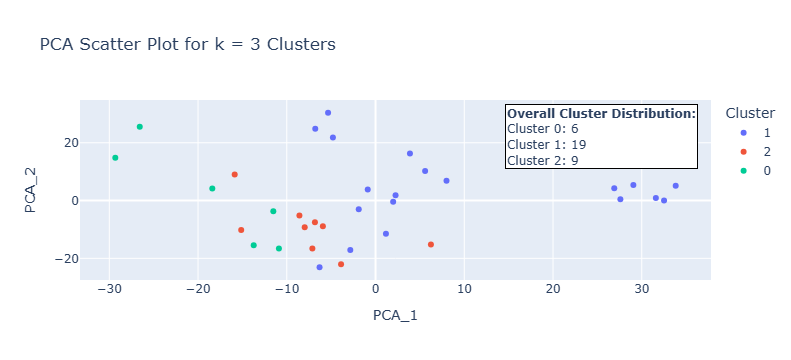

Interactive PCA Scatter Plot for k=3 saved as: ./assets/cluster_semantic/cluster_scatter_3.html


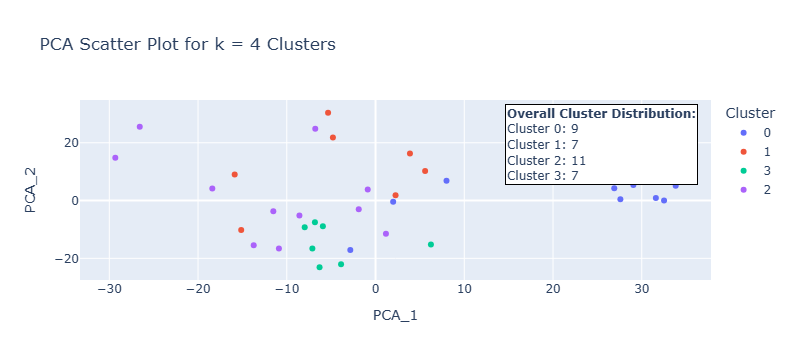

Interactive PCA Scatter Plot for k=4 saved as: ./assets/cluster_semantic/cluster_scatter_4.html


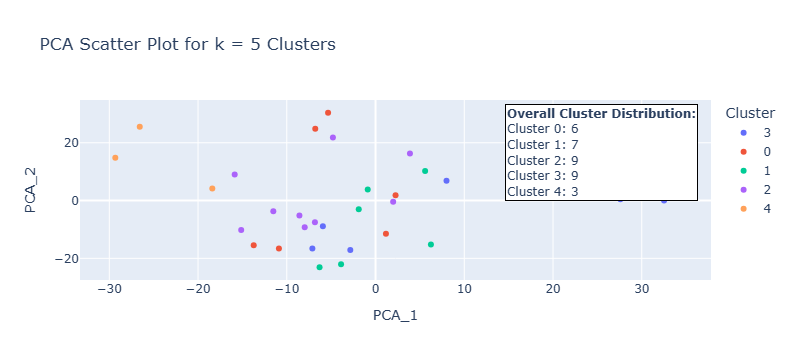

Interactive PCA Scatter Plot for k=5 saved as: ./assets/cluster_semantic/cluster_scatter_5.html


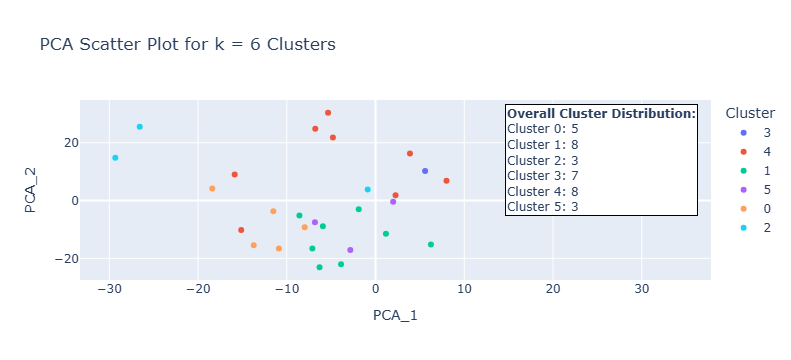

Interactive PCA Scatter Plot for k=6 saved as: ./assets/cluster_semantic/cluster_scatter_6.html


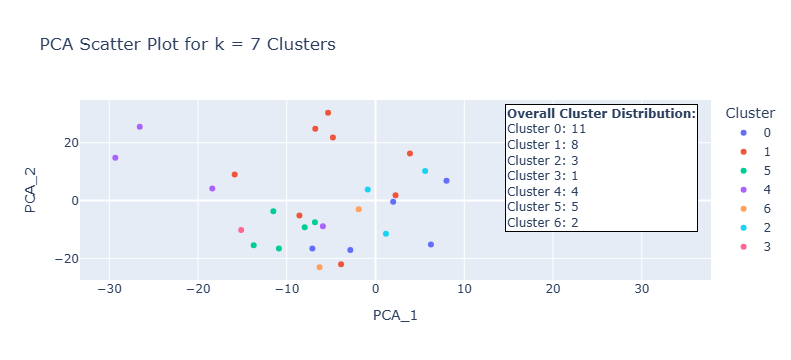

Interactive PCA Scatter Plot for k=7 saved as: ./assets/cluster_semantic/cluster_scatter_7.html


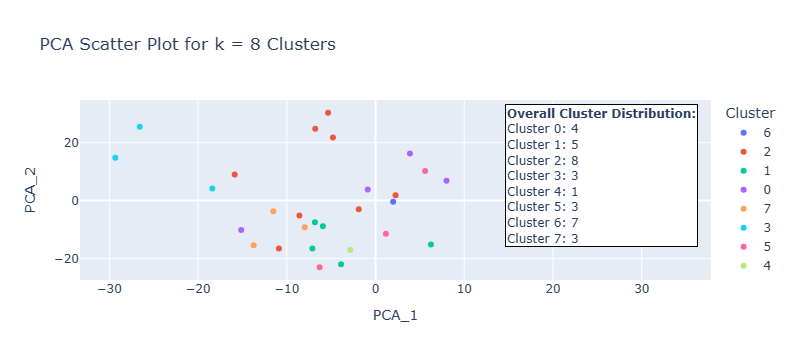

Interactive PCA Scatter Plot for k=8 saved as: ./assets/cluster_semantic/cluster_scatter_8.html


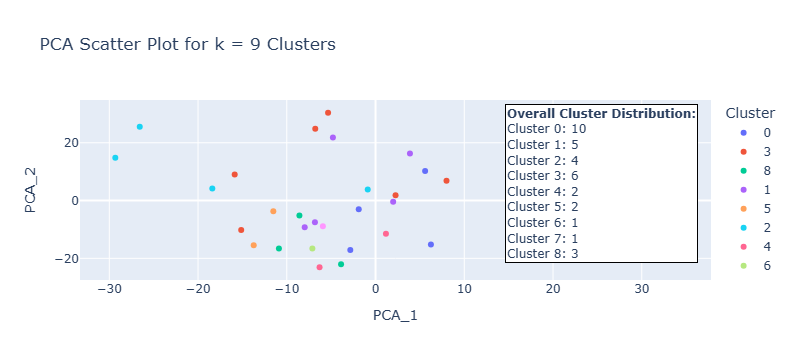

Interactive PCA Scatter Plot for k=9 saved as: ./assets/cluster_semantic/cluster_scatter_9.html


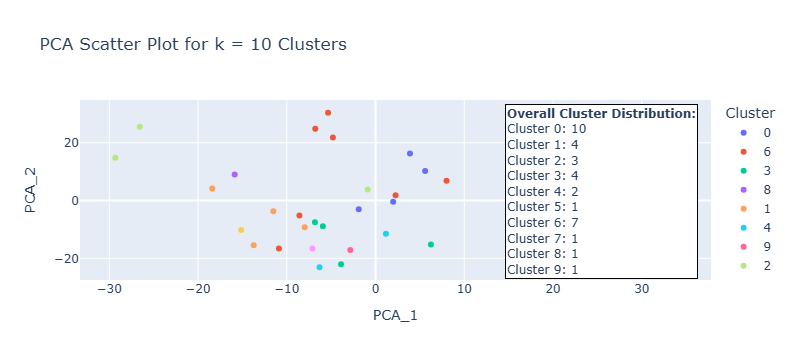

Interactive PCA Scatter Plot for k=10 saved as: ./assets/cluster_semantic/cluster_scatter_10.html


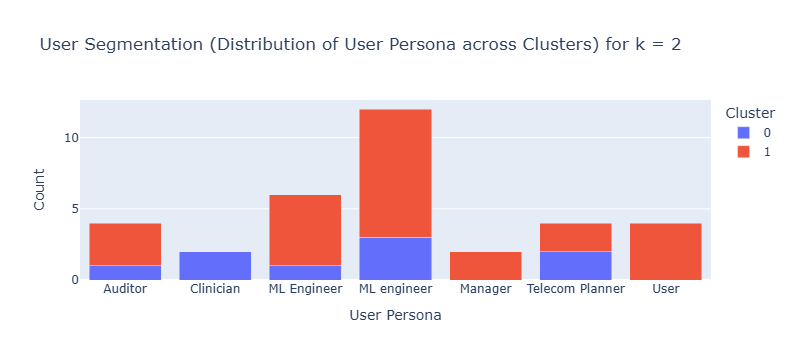

Interactive User Segmentation Bar Chart for k=2 saved as: ./assets/cluster_semantic/user_segmentation_k_2.html


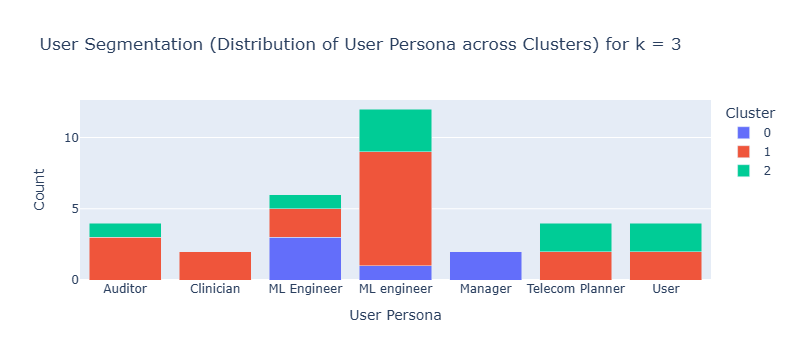

Interactive User Segmentation Bar Chart for k=3 saved as: ./assets/cluster_semantic/user_segmentation_k_3.html


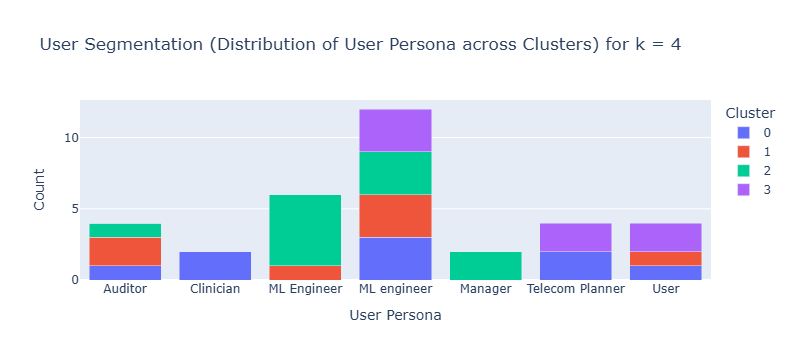

Interactive User Segmentation Bar Chart for k=4 saved as: ./assets/cluster_semantic/user_segmentation_k_4.html


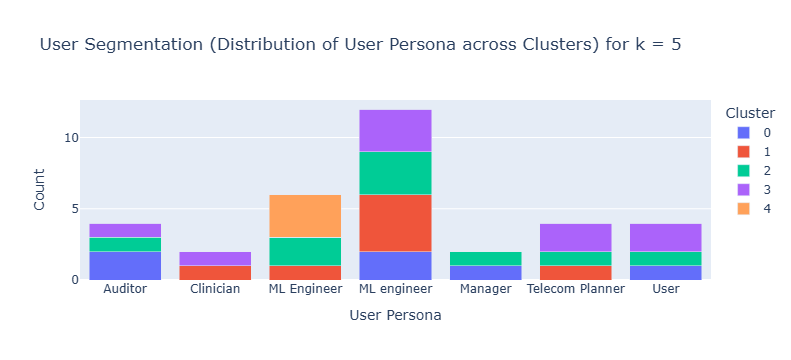

Interactive User Segmentation Bar Chart for k=5 saved as: ./assets/cluster_semantic/user_segmentation_k_5.html


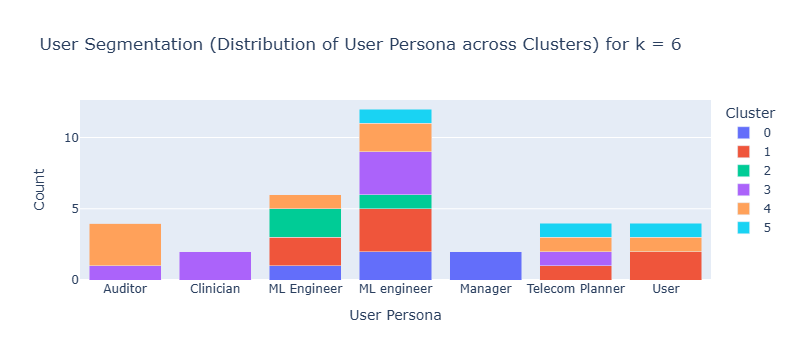

Interactive User Segmentation Bar Chart for k=6 saved as: ./assets/cluster_semantic/user_segmentation_k_6.html


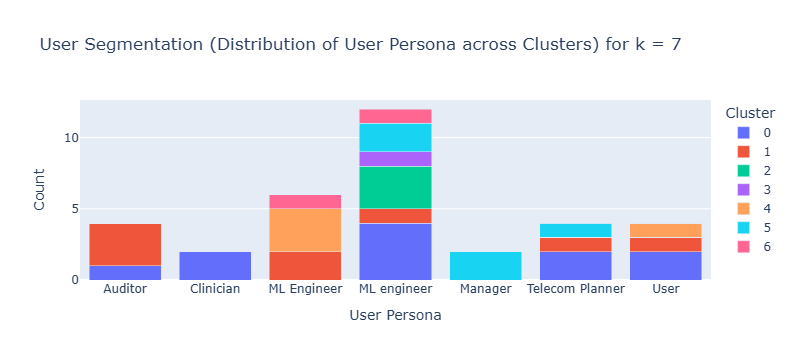

Interactive User Segmentation Bar Chart for k=7 saved as: ./assets/cluster_semantic/user_segmentation_k_7.html


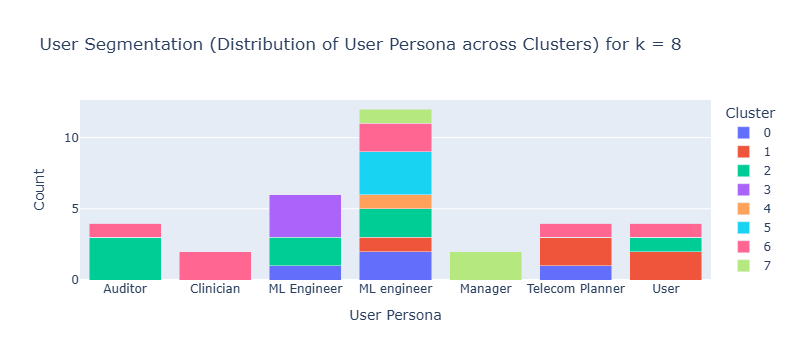

Interactive User Segmentation Bar Chart for k=8 saved as: ./assets/cluster_semantic/user_segmentation_k_8.html


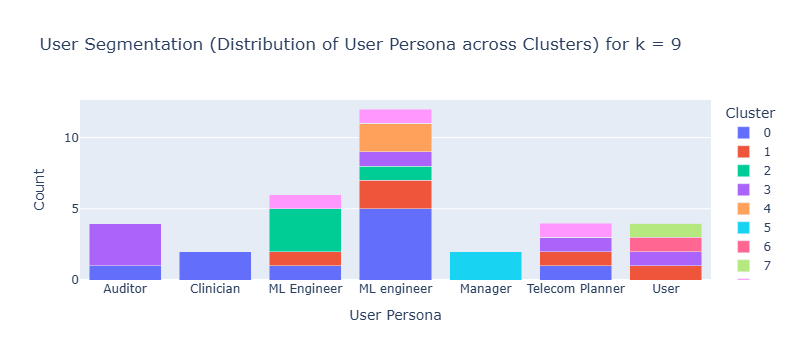

Interactive User Segmentation Bar Chart for k=9 saved as: ./assets/cluster_semantic/user_segmentation_k_9.html


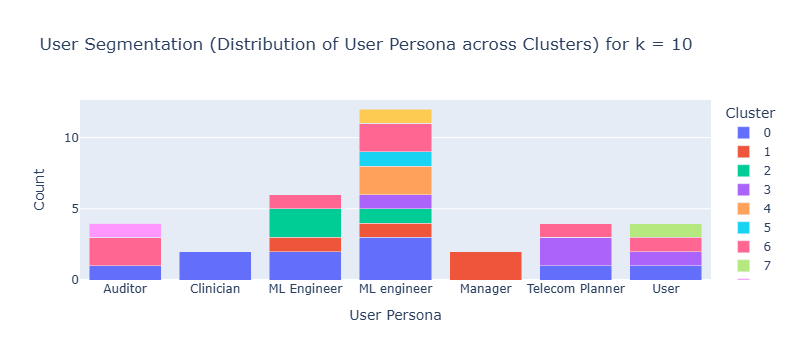

Interactive User Segmentation Bar Chart for k=10 saved as: ./assets/cluster_semantic/user_segmentation_k_10.html


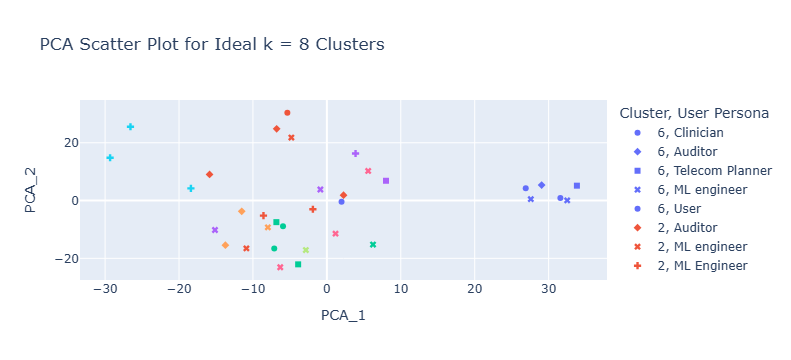

Interactive PCA Scatter Plot for ideal clusters saved as: ./assets/cluster_semantic/ideal_cluster_scatter.html
Final clustered data saved as: ./assets/cluster_semantic/final_cluster_data.csv


In [109]:
cluster_interaction_analysis(list(qa_interaction_data.values()), question_emb_dict)

## Regression Analysis With Reasonability Score

In [134]:
def analyze_interaction_metrics(data, predictors=None):
    """
    Analyzes readability, complexity, and reasonability scores for user interactions.
    
    Each dictionary in the input list should contain:
      - "usecase_name": String (categorical)
      - "explainer_types": List of strings (e.g., ["Type A", "Visual"])
      - "question": String
      - "answer": String
      - "user_persona": String (categorical)
      - "reasonability_score": Integer between 1 and 10
    
    The function computes a variety of text metrics for both questions and answers,
    displays a detailed summary of the initial DataFrame, shows an enlarged full correlation heatmap
    (excluding the "Reasonability Score"), prints the top 10 most correlated pairs between question
    and answer metrics (excluding outcome columns), displays a separate heatmap for these top correlations,
    and performs regression analysis to predict the reasonability score using selected predictors.
    
    Args:
        data (list of dicts): List of interaction data dictionaries.
        predictors (list of str, optional): List of column names to use as predictors in regression.
            If None, a default set will be used.
    
    Returns:
        pd.DataFrame: The DataFrame containing computed metrics for each interaction.
    """
    import os
    import textstat
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MultiLabelBinarizer

    # -------------------- Compute Metrics --------------------
    results = []
    for interaction in data:
        usecase_name         = interaction.get("usecase_name", None)
        explainer_types      = interaction.get("explainer_types", [])  # expected list
        question             = interaction.get("question", "")
        answer               = interaction.get("answer", "")
        user_persona         = interaction.get("user_persona", None)
        reasonability_score  = interaction.get("reasonability_score", np.nan)
        
        metrics = {
            # Basic counts:
            "Question Length": len(question),
            "Answer Length": len(answer),
            "Question Word Count": textstat.lexicon_count(question, removepunct=True),
            "Answer Word Count": textstat.lexicon_count(answer, removepunct=True),
            "Question Sentence Count": textstat.sentence_count(question),
            "Answer Sentence Count": textstat.sentence_count(answer),
            "Question Syllable Count": textstat.syllable_count(question),
            "Answer Syllable Count": textstat.syllable_count(answer),
            
            # Averages:
            "Question Avg Words per Sentence": textstat.lexicon_count(question) / max(1, textstat.sentence_count(question)),
            "Question Avg Syllables per Word": textstat.syllable_count(question) / max(1, textstat.lexicon_count(question)),
            "Answer Avg Words per Sentence": textstat.lexicon_count(answer) / max(1, textstat.sentence_count(answer)),
            "Answer Avg Syllables per Word": textstat.syllable_count(answer) / max(1, textstat.lexicon_count(answer)),
            
            # Readability for question:
            "Question Flesch Reading Ease": textstat.flesch_reading_ease(question),
            "Question Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(question),
            "Question Gunning Fog Index": textstat.gunning_fog(question),
            "Question SMOG Index": textstat.smog_index(question),
            "Question Dale-Chall Score": textstat.dale_chall_readability_score(question),
            "Question Coleman-Liau Index": textstat.coleman_liau_index(question),
            
            # Readability for answer:
            "Answer Flesch Reading Ease": textstat.flesch_reading_ease(answer),
            "Answer Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(answer),
            "Answer Gunning Fog Index": textstat.gunning_fog(answer),
            "Answer SMOG Index": textstat.smog_index(answer),
            "Answer Dale-Chall Score": textstat.dale_chall_readability_score(answer),
            "Answer Coleman-Liau Index": textstat.coleman_liau_index(answer),
            
            # Outcome and categoricals:
            "Reasonability Score": reasonability_score,
            "Usecase Name": usecase_name,
            "Explainer Types": explainer_types,  # keep as list for processing below
            "User Persona": user_persona,
        }
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # -------------------- Process "Explainer Types" --------------------
    if "Explainer Types" in df.columns and not df["Explainer Types"].isnull().all():
        sample_val = df["Explainer Types"].dropna().iloc[0]
        if isinstance(sample_val, list):
            mlb = MultiLabelBinarizer()
            explainer_dummies = pd.DataFrame(
                mlb.fit_transform(df["Explainer Types"]),
                columns=[f"Explainer Types_{cat}" for cat in mlb.classes_],
                index=df.index
            )
            df = pd.concat([df, explainer_dummies], axis=1)
            df.drop(columns=["Explainer Types"], inplace=True)
        
    # -------------------- Regression Analysis --------------------
    print("\n📌 Regression Analysis (Predicting Reasonability Score):")
    if predictors is None:
        predictors = [
            "Answer Word Count", "Answer Sentence Count", "Answer Avg Words per Sentence",
            "Answer Avg Syllables per Word", "Answer Flesch Reading Ease",
            "User Persona", "Usecase Name"
        ]
        explainer_dummy_cols = [col for col in df.columns if col.startswith("Explainer Types_")]
        predictors.extend(explainer_dummy_cols)
    
    df_reg = df.copy()
    final_predictors = []
    for col in predictors.copy():
        if col in df_reg.columns and not pd.api.types.is_numeric_dtype(df_reg[col]):
            dummies = pd.get_dummies(df_reg[col], prefix=col, drop_first=True)
            df_reg = pd.concat([df_reg, dummies], axis=1)
            predictors.remove(col)
            final_predictors.extend(dummies.columns.tolist())
        else:
            final_predictors.append(col)
    
    df_reg = df_reg.dropna(subset=final_predictors + ["Reasonability Score"])
    if df_reg.empty:
        print("No data remains for regression analysis after dropping missing values.")
        return df
    
    X = df_reg[final_predictors]
    y = df_reg["Reasonability Score"]
    
    # Convert to numeric explicitly.
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    reg_df = X.join(y).dropna()
    X = reg_df[X.columns].astype(float)
    y = reg_df["Reasonability Score"].astype(float)
    
    if X.shape[0] == 0 or X.shape[1] == 0:
        print("Regression predictors array is empty. Check your predictors and data.")
        return df
    
    X = sm.add_constant(X)
    try:
        # Convert X and y to numpy arrays with dtype float.
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        model = sm.OLS(y, X).fit()
        print(model.summary())
    except Exception as e:
        print("An error occurred during regression modeling:", e)
    

In [130]:
with open("./assets/llm_reasonability_stats/stats_average.json", "r") as f:
    reasonability_stats_dict = json.load(f)

In [131]:
for q in qa_interaction_data:
    stat = reasonability_stats_dict[q]

    qa_interaction_data[q]["reasonability_score"] = stat["average"]

In [135]:
analyze_interaction_metrics(list(qa_interaction_data.values()))


📌 Regression Analysis (Predicting Reasonability Score):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     5.407
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           0.000454
Time:                        18:39:57   Log-Likelihood:                -21.369
No. Observations:                  34   AIC:                             72.74
Df Residuals:                      19   BIC:                             95.63
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Sentiment Analysis of Clarifications

In [166]:
from prompts.llm_sentiment_analysis_template import *
from utils.llm_base import *

In [167]:
def get_sentiment_via_llm(text):
    sentiment_instructions = generate_sentiment_classification_template()
    sentiment_instructions = sentiment_instructions.replace("$text_input", text)

    sentiment = GPT_4o_model.inference_with_json(sentiment_instructions).choices[0].message.content
    sentiment = json.loads(sentiment)["sentiment"]
    
    return sentiment

In [169]:
GPT_4o_CONFIG = {
    "model": "gpt-4o-2024-08-06",
    "api_key": os.environ["OPENAI_API_KEY"] ,
    "temperature": 0.0,
}
GPT_4o_model = GPT4o_Model(GPT_4o_CONFIG)

In [170]:
def sentiment_analysis_interactions(data, custom_llm_sentiment_function=get_sentiment_via_llm):
    """
    Performs sentiment analysis on chat interactions. For each interaction, the function computes:
      - Basic text metrics (e.g., lengths, word counts, sentence counts, syllable counts).
      - Sentiment classifications for both the question and the answer using VADER.
      - Sentiment classifications using a custom LLM-based method.
    
    Sentiment compound scores are classified into three categories:
      - "Positive" if compound score >= 0.05
      - "Negative" if compound score <= -0.05
      - "Neutral" otherwise
    
    The function then generates interactive Plotly visualizations to show:
      - Distribution of VADER sentiment classifications by User Persona.
      - Distribution of VADER sentiment classifications by Usecase Name.
      - Scatter plots (using a strip plot format) showing how sentiment classifications (LLM-based)
        vary with the Reasonability Score.
      - Comparison plots (strip plots) of VADER vs. LLM sentiment classifications for both questions and answers.
      - **Additional Plots Based on LLM Sentiment:**
          • Distribution of Question LLM Sentiment by Usecase Name.
          • Distribution of Answer LLM Sentiment by User Persona.
          • Distribution of Question LLM Sentiment by Explainer Types.
          • Distribution of Answer LLM Sentiment by Explainer Types.
    
    All plots are saved as HTML files in an "assets" folder and are also displayed inline.
    The processed dataset is saved as "./assets/sentiment_dataset.csv".
    
    Args:
        data (list of dicts): List of interaction dictionaries. Each dictionary should include:
            - "usecase_name": String (categorical)
            - "explainer_types": List of strings (e.g., ["Type A", "Visual"])
            - "question": String
            - "answer": String
            - "user_persona": String (categorical)
            - "reasonability_score": Integer between 1 and 10
        custom_llm_sentiment_function (callable, optional): A function that takes a text string and returns 
            a numeric sentiment compound score. If not provided, a default placeholder using VADER is used.
    """
    # Ensure the assets folder exists.
    assets_folder = "./assets/sentiment_analysis/"
    os.makedirs(assets_folder, exist_ok=True)
    
    # Helper function to classify sentiment.
    def classify_sentiment(compound, threshold=0.05):
        if compound >= threshold:
            return "Positive"
        elif compound <= -threshold:
            return "Negative"
        else:
            return "Neutral"
    
    # Create an instance of the VADER sentiment analyzer.
    vader_analyzer = SentimentIntensityAnalyzer()
    
    # Define a default custom LLM sentiment function if none is provided.
    if custom_llm_sentiment_function is None:
        def custom_llm_sentiment_function(text):
            # Default placeholder: use VADER compound score.
            return vader_analyzer.polarity_scores(text)["compound"]
    
    # -------------------- Compute Metrics and Sentiment --------------------
    results = []
    for interaction in tqdm(data):
        usecase_name         = interaction.get("usecase_name", None)
        explainer_types      = interaction.get("explainer_types", [])  # not used for sentiment computation
        question             = interaction.get("question", "")
        answer               = interaction.get("answer", "")
        user_persona         = interaction.get("user_persona", None)
        reasonability_score  = interaction.get("reasonability_score", np.nan)
        
        # Compute basic text metrics.
        metrics = {
            "Question Length": len(question),
            "Answer Length": len(answer),
            "Question Word Count": textstat.lexicon_count(question, removepunct=True),
            "Answer Word Count": textstat.lexicon_count(answer, removepunct=True),
            "Question Sentence Count": textstat.sentence_count(question),
            "Answer Sentence Count": textstat.sentence_count(answer),
            "Question Syllable Count": textstat.syllable_count(question),
            "Answer Syllable Count": textstat.syllable_count(answer),
        }
        
        # Compute VADER sentiment scores and classify.
        q_vader = vader_analyzer.polarity_scores(question)
        a_vader = vader_analyzer.polarity_scores(answer)
        metrics["Question VADER Sentiment"] = classify_sentiment(q_vader["compound"])
        metrics["Answer VADER Sentiment"] = classify_sentiment(a_vader["compound"])
        
        # Compute custom LLM sentiment scores and classify.
        q_custom = custom_llm_sentiment_function(question)
        a_custom = custom_llm_sentiment_function(answer)
        metrics["Question LLM Sentiment"] = q_custom
        metrics["Answer LLM Sentiment"] = a_custom
        
        # Also, store the raw LLM compound scores (if needed for quantitative analysis).
        metrics["Question LLM Raw"] = q_custom
        metrics["Answer LLM Raw"] = a_custom
        
        # Outcome and categoricals.
        metrics["Reasonability Score"] = reasonability_score
        metrics["Usecase Name"] = usecase_name
        metrics["User Persona"] = user_persona
        # For potential analysis by explainer types, join the list into a single string.
        metrics["Explainer Types"] = ", ".join(explainer_types) if explainer_types else "None"
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(assets_folder, "sentiment_dataset.csv"), index=False)
    
    # # -------------------- Print Detailed Initial DataFrame --------------------
    # pd.set_option("display.max_columns", None)
    # pd.set_option("display.width", 250)
    # print("\n=== Sentiment Analysis DataFrame ===")
    # print("Shape:", df.shape)
    # print(df.head(10).to_string(index=False))
    
    # -------------------- Interactive Plots --------------------
    # 1. Distribution of Question VADER Sentiment by User Persona.
    fig_q_vader = px.box(df, x="User Persona", y="Question VADER Sentiment",
                         title="Distribution of Question VADER Sentiment by User Persona",
                         category_orders={"Question VADER Sentiment": ["Negative", "Neutral", "Positive"]})
    q_vader_output = os.path.join(assets_folder, "question_vader_by_user_persona.html")
    fig_q_vader.write_html(q_vader_output)
    fig_q_vader.show()
    print("Interactive Question VADER Sentiment by User Persona plot saved as:", q_vader_output)
    
    # 2. Distribution of Answer VADER Sentiment by Usecase Name.
    fig_a_vader = px.box(df, x="Usecase Name", y="Answer VADER Sentiment",
                         title="Distribution of Answer VADER Sentiment by Usecase Name",
                         category_orders={"Answer VADER Sentiment": ["Negative", "Neutral", "Positive"]})
    a_vader_output = os.path.join(assets_folder, "answer_vader_by_usecase.html")
    fig_a_vader.write_html(a_vader_output)
    fig_a_vader.show()
    print("Interactive Answer VADER Sentiment by Usecase Name plot saved as:", a_vader_output)
    
    # 3. Scatter Plot: Reasonability Score vs. Question LLM Sentiment, colored by User Persona.
    fig_scatter_q = px.strip(df, x="Question LLM Sentiment", y="Reasonability Score",
                             color="User Persona",
                             title="Reasonability Score vs. Question LLM Sentiment",
                             category_orders={"Question LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    scatter_q_output = os.path.join(assets_folder, "reasonability_vs_question_llm.html")
    fig_scatter_q.write_html(scatter_q_output)
    fig_scatter_q.show()
    print("Interactive Scatter Plot (Reasonability vs. Question LLM Sentiment) saved as:", scatter_q_output)
    
    # 4. Scatter Plot: Reasonability Score vs. Answer LLM Sentiment, colored by Usecase Name.
    fig_scatter_a = px.strip(df, x="Answer LLM Sentiment", y="Reasonability Score",
                             color="Usecase Name",
                             title="Reasonability Score vs. Answer LLM Sentiment",
                             category_orders={"Answer LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    scatter_a_output = os.path.join(assets_folder, "reasonability_vs_answer_llm.html")
    fig_scatter_a.write_html(scatter_a_output)
    fig_scatter_a.show()
    print("Interactive Scatter Plot (Reasonability vs. Answer LLM Sentiment) saved as:", scatter_a_output)
    
    # 5. Comparison Plot: VADER vs. LLM Sentiment for Questions.
    fig_compare_q = px.strip(df, x="Question VADER Sentiment", y="Question LLM Sentiment",
                             color="User Persona",
                             title="Comparison of VADER and LLM Sentiment (Question)",
                             category_orders={"Question VADER Sentiment": ["Negative", "Neutral", "Positive"],
                                              "Question LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    compare_q_output = os.path.join(assets_folder, "compare_question_sentiments.html")
    fig_compare_q.write_html(compare_q_output)
    fig_compare_q.show()
    print("Interactive Comparison Plot for Question Sentiments saved as:", compare_q_output)
    
    # 6. Comparison Plot: VADER vs. LLM Sentiment for Answers.
    fig_compare_a = px.strip(df, x="Answer VADER Sentiment", y="Answer LLM Sentiment",
                             color="Usecase Name",
                             title="Comparison of VADER and LLM Sentiment (Answer)",
                             category_orders={"Answer VADER Sentiment": ["Negative", "Neutral", "Positive"],
                                              "Answer LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    compare_a_output = os.path.join(assets_folder, "compare_answer_sentiments.html")
    fig_compare_a.write_html(compare_a_output)
    fig_compare_a.show()
    print("Interactive Comparison Plot for Answer Sentiments saved as:", compare_a_output)
    
    # --------- Additional Plots Based on LLM Sentiment ---------
    # 7. Distribution of Question LLM Sentiment by Usecase Name.
    fig_qllm_usecase = px.histogram(df, x="Usecase Name", color="Question LLM Sentiment",
                                    barmode="group",
                                    title="Distribution of Question LLM Sentiment by Usecase Name",
                                    category_orders={"Question LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    qllm_usecase_output = os.path.join(assets_folder, "question_llm_by_usecase.html")
    fig_qllm_usecase.write_html(qllm_usecase_output)
    fig_qllm_usecase.show()
    print("Interactive Distribution Plot for Question LLM Sentiment by Usecase Name saved as:", qllm_usecase_output)
    
    # 8. Distribution of Answer LLM Sentiment by User Persona.
    fig_allm_persona = px.histogram(df, x="User Persona", color="Answer LLM Sentiment",
                                    barmode="group",
                                    title="Distribution of Answer LLM Sentiment by User Persona",
                                    category_orders={"Answer LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    allm_persona_output = os.path.join(assets_folder, "answer_llm_by_user_persona.html")
    fig_allm_persona.write_html(allm_persona_output)
    fig_allm_persona.show()
    print("Interactive Distribution Plot for Answer LLM Sentiment by User Persona saved as:", allm_persona_output)
    
    # 9. Distribution of Question LLM Sentiment by Explainer Types.
    fig_qllm_explainer = px.histogram(df, x="Explainer Types", color="Question LLM Sentiment",
                                      barmode="group",
                                      title="Distribution of Question LLM Sentiment by Explainer Types",
                                      category_orders={"Question LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    qllm_explainer_output = os.path.join(assets_folder, "question_llm_by_explainer.html")
    fig_qllm_explainer.write_html(qllm_explainer_output)
    fig_qllm_explainer.show()
    print("Interactive Distribution Plot for Question LLM Sentiment by Explainer Types saved as:", qllm_explainer_output)
    
    # 10. Distribution of Answer LLM Sentiment by Explainer Types.
    fig_allm_explainer = px.histogram(df, x="Explainer Types", color="Answer LLM Sentiment",
                                      barmode="group",
                                      title="Distribution of Answer LLM Sentiment by Explainer Types",
                                      category_orders={"Answer LLM Sentiment": ["Negative", "Neutral", "Positive"]})
    allm_explainer_output = os.path.join(assets_folder, "answer_llm_by_explainer.html")
    fig_allm_explainer.write_html(allm_explainer_output)
    fig_allm_explainer.show()
    print("Interactive Distribution Plot for Answer LLM Sentiment by Explainer Types saved as:", allm_explainer_output)
    
    # The function does not return any value.


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:51<00:00,  1.50s/it]


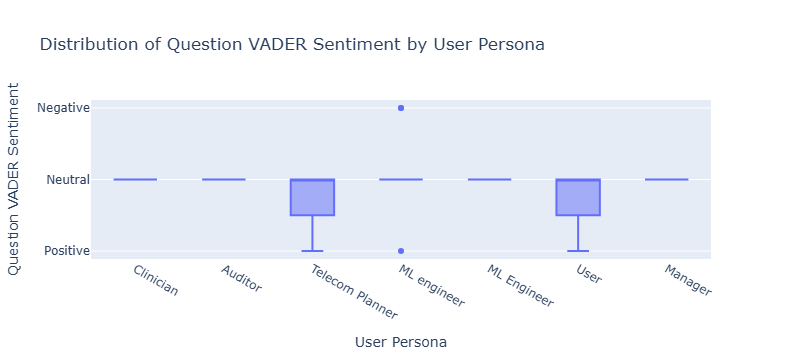

Interactive Question VADER Sentiment by User Persona plot saved as: ./assets/sentiment_analysis/question_vader_by_user_persona.html


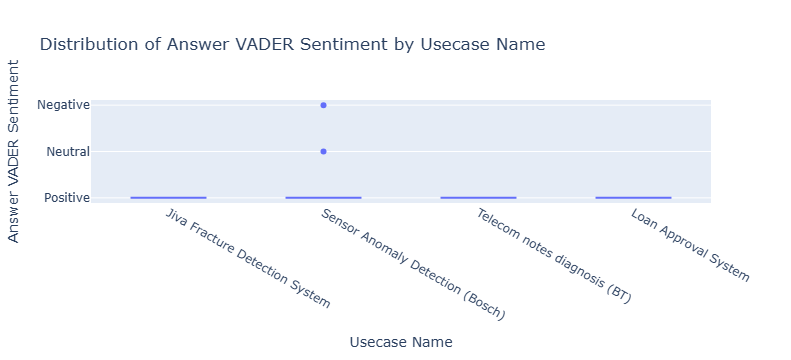

Interactive Answer VADER Sentiment by Usecase Name plot saved as: ./assets/sentiment_analysis/answer_vader_by_usecase.html


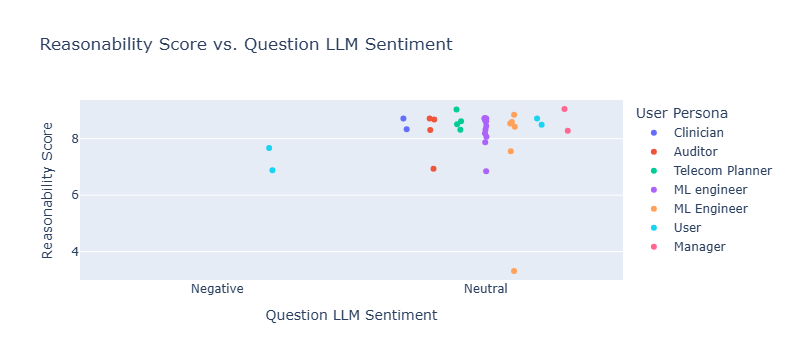

Interactive Scatter Plot (Reasonability vs. Question LLM Sentiment) saved as: ./assets/sentiment_analysis/reasonability_vs_question_llm.html


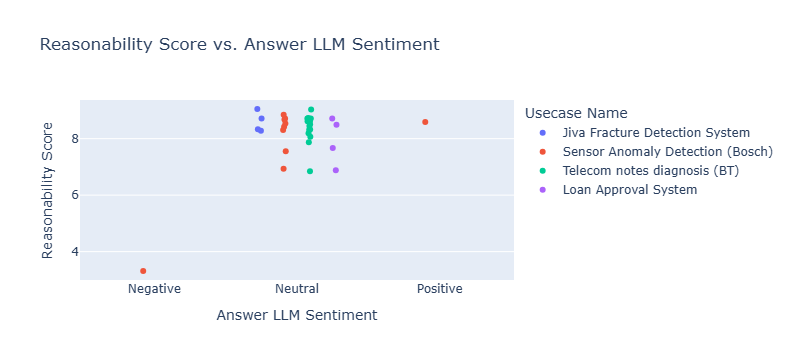

Interactive Scatter Plot (Reasonability vs. Answer LLM Sentiment) saved as: ./assets/sentiment_analysis/reasonability_vs_answer_llm.html


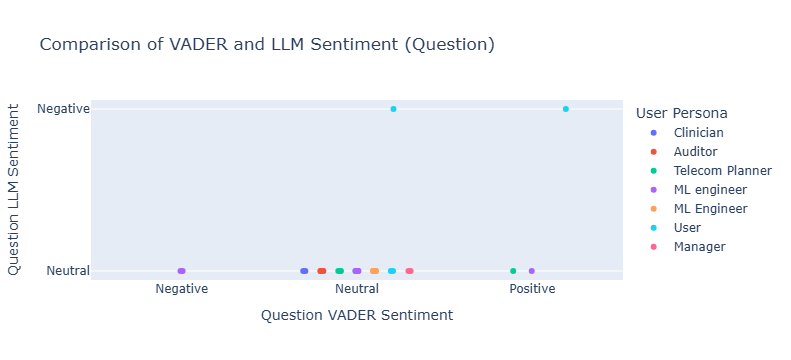

Interactive Comparison Plot for Question Sentiments saved as: ./assets/sentiment_analysis/compare_question_sentiments.html


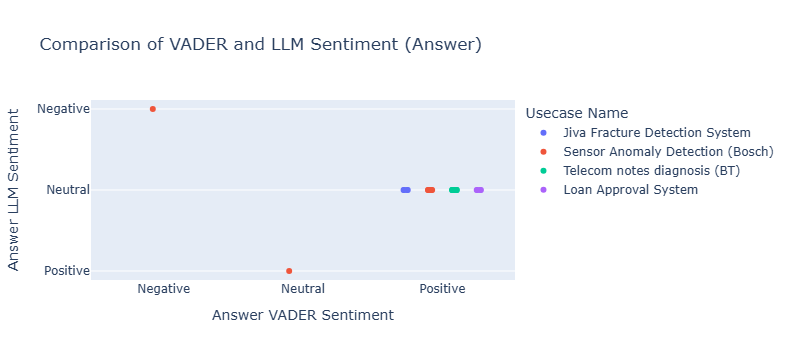

Interactive Comparison Plot for Answer Sentiments saved as: ./assets/sentiment_analysis/compare_answer_sentiments.html


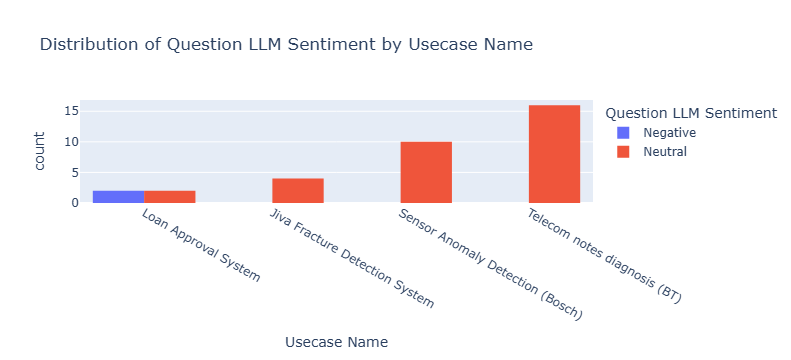

Interactive Distribution Plot for Question LLM Sentiment by Usecase Name saved as: ./assets/sentiment_analysis/question_llm_by_usecase.html


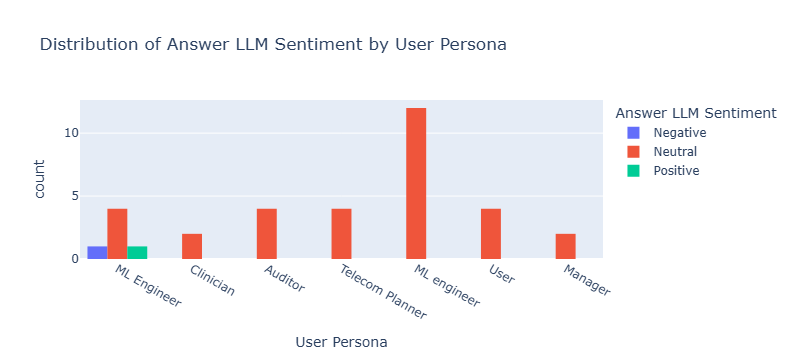

Interactive Distribution Plot for Answer LLM Sentiment by User Persona saved as: ./assets/sentiment_analysis/answer_llm_by_user_persona.html


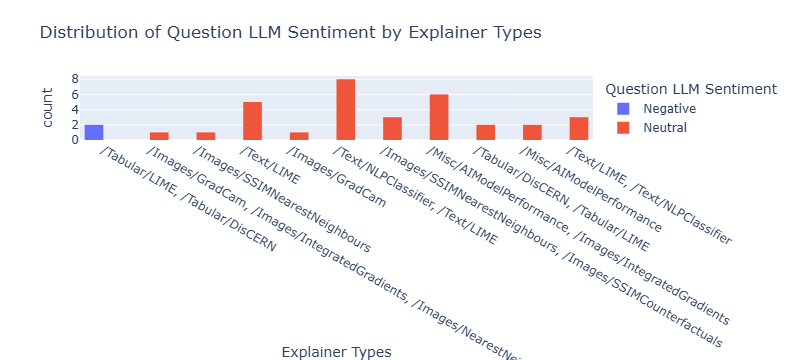

Interactive Distribution Plot for Question LLM Sentiment by Explainer Types saved as: ./assets/sentiment_analysis/question_llm_by_explainer.html


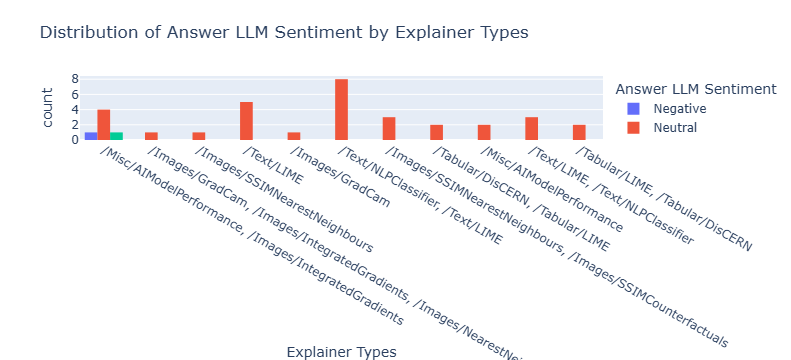

Interactive Distribution Plot for Answer LLM Sentiment by Explainer Types saved as: ./assets/sentiment_analysis/answer_llm_by_explainer.html


In [171]:
sentiment_analysis_interactions(list(qa_interaction_data.values()))

## Sentiment Analysis Report

## Overview

This analysis evaluated the sentiment of chat interactions using two complementary methods: the VADER sentiment analyzer and a custom LLM-based sentiment classifier. Both methods compute a compound sentiment score for the question and answer texts, which are then classified into three categories—**Positive**, **Neutral**, and **Negative**—using the following thresholds:

- **Positive:** Compound score ≥ 0.05  
- **Negative:** Compound score ≤ -0.05  
- **Neutral:** Otherwise

The analysis also explored how these sentiment classifications relate to the reasonability scores of the responses and how they vary across different user segments (by user persona, usecase, and explainer types).

## Methodology

1. **VADER Sentiment Analysis**  
   - The VADER tool calculates compound sentiment scores based on a lexicon and rule-based approach.
   - These compound scores are then classified into Positive, Neutral, or Negative.
   - Observations indicate that VADER tends to classify a higher proportion of interactions as Positive, possibly due to the sensitivity of its threshold settings.

2. **Custom LLM-Based Sentiment Analysis**  
   - A custom sentiment function (designed to leverage a large language model) to produce  direct label.
   - The LLM-based method shows a somewhat different distribution, often resulting in a higher incidence of Neutral classifications.
3. **Correlation with Reasonability Scores**  
   - A correlation analysis was performed to determine how sentiment relates to the reasonability score of an answer.
   - It was found that interactions with **negative sentiment** (especially as classified by the LLM-based approach) tended to have lower reasonability scores. For example, responses such as "I cannot assist you with that"—which are often negative—correlate with lower scores.
   - Conversely, Positive or Neutral sentiment classifications were associated with more variable reasonability scores, suggesting that a less extreme sentiment may not have a clear impact on the perceived reasonability of the response.

## Key Findings

- **VADER vs. LLM Sentiment Classifications:**  
  - **VADER** tends to produce a bias toward positive sentiment classifications, likely because its fixed threshold settings capture more nuances as "positive."  
  - The **LLM-based sentiment classifier**, however, is more conservative and may classify more interactions as Neutral.

- **Correlation with Reasonability Scores:**  
  - Negative sentiment responses are generally correlated with lower reasonability scores. This may indicate that when the system produces a negative response (e.g., "I cannot assist you with that"), it is reflecting a justifiable output that is rated lower in terms of overall reasonability.
  - Positive and Neutral sentiment interactions display a broader range of reasonability scores, suggesting that the sentiment tone (when not strongly negative) does not directly predict the quality of the response.

- **Implications for Future Studies:**  
  - The observed correlation between negative sentiment and lower reasonability scores highlights an opportunity to further segment user interactions. In practice, this could help in tailoring responses or flagging interactions for additional review.
  - Although this study offers promising initial insights, a larger-scale study is needed to confirm these trends and to refine sentiment thresholds for more accurate predictions.

